In [1]:
import obspy
import glob
from obspy import UTCDateTime as UTC
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import glob
import sys
import pandas as pd
from math import sin, cos, sqrt, atan2, radians, isnan, floor, ceil
from scipy import signal
import pickle
import json
import pyrocko
from pyrocko import cake
from pyrocko.plot import cake_plot
import csv
import os

# WSS

In [2]:
### load JMA catalog

dframe=pd.read_excel('/nfs/turbo/lsa-zspica/work/yaolinm/for_jiuxun/JMA.xlsx')
magnitude=dframe['Magnitude']
latitude=dframe['Latitude']
longitude=dframe['Longitude']
date=dframe['Date']
time=dframe['Time']
depth=dframe['Depth']
index=dframe['Index']
for i in range(len(magnitude)):
    if magnitude[i] !=magnitude[i]:
        magnitude[i]=0
    else:
        magnitude[i]=float(magnitude[i][0:3])
        
### load cable locations

stations = pd.read_csv('/nfs/turbo/lsa-zspica/work/yaolinm/for_jiuxun/Channel_position_LV_v2.csv',header=None,delimiter=',')
lats=stations[1]
lons=stations[2]

daslat=39.2633725374648 
daslon=142.144805409815

/tmp/ipykernel_3240539/194883350.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  magnitude[i]=float(magnitude[i][0:3])
/tmp/ipykernel_3240539/194883350.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  magnitude[i]=0


In [9]:
def cal_dis(lati1,long1,lati2,long2):
    R = 6373.0
    
    lat1 = radians(lati1)
    lon1 = radians(long1)
    lat2 = radians(lati2)
    lon2 = radians(long2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    
    return distance

def check_delta(d_value,d_list):
    for x in d_list: 
        if d_value >= x: 
            return False
    return True

def sort_by_n(event_list,channel_list,thre):
    
    assert len(event_list)==len(channel_list) 
    n_list=[]
    for i in range(len(channel_list)):
        n_list.append(len(channel_list[i]))
        
    order=np.argsort(n_list)[::-1]
    
    output_event=[]
    output_channel=[]
    
    output_event.append(UTC(event_list[order[0]]))
    output_channel.append(channel_list[order[0]])
    
    for i in range(1,len(order)):
        event=UTC(event_list[order[i]])
        for k in range(int(-thre/2),int(thre/2)):
            if event-k in output_event:
                break
        else:
            output_event.append(event)
            output_channel.append(channel_list[order[i]])
            
    for o in range(len(output_event)):
        oe=output_event[o]
        index=event_list.index(oe)
        assert channel_list[index] == output_channel[o]
    
    return output_event,output_channel

def correspond(files,N):
    all_events=[]
    all_channels=[]
    
    for file in files:
        channel_list=[]
        events=[]
        event_channels=[]
        
        with open(file,'rb') as fp:
            times=pickle.load(fp)
        for t in range(0,5):
            channel_list.append([])
            
        for t in range(5,3585):
            temp=[]
            for ch in times[t]:
                if ch >300:
                    temp.append(ch)
            channel_list.append(temp)
            
        for t in range(3585,3600):
            channel_list.append([])
        
        for i in range(len(channel_list)):
            if len(channel_list[i]) >=N:
                events.append(UTC(2019,11,20,0,0,24)+9*3600+i+int(file[-9:-6])*3600)
                event_channels.append(channel_list[i])
                
        if len(events)>0:
            events,channels=sort_by_n(events,event_channels,28)
            all_events.extend(events)
            all_channels.extend(channels)

    return all_events, all_channels


In [30]:
files=glob.glob('/nfs/turbo/lsa-zspica/work/yaolinm/from_scratch/sortings9/*.txt')
files.sort()
n=30   
tm_detections,all_channel=correspond(files,n)

In [31]:
len(tm_detections)

10200

In [6]:
newfile='/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/final_catalog_14s/WSS/all_WSS_detections.txt'
f=open(newfile,'w+')
for detection in tm_detections:
    f.write(str(detection)+'\n')
f.close()

In [10]:
ns=[10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120] 
counts=[]
for n in ns:
    temp_tm_detections,temp_all_channel=correspond(files,n)
    print(n)
    counts.append(len(temp_tm_detections))

10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120


Text(0.5, 0, 'N channel')

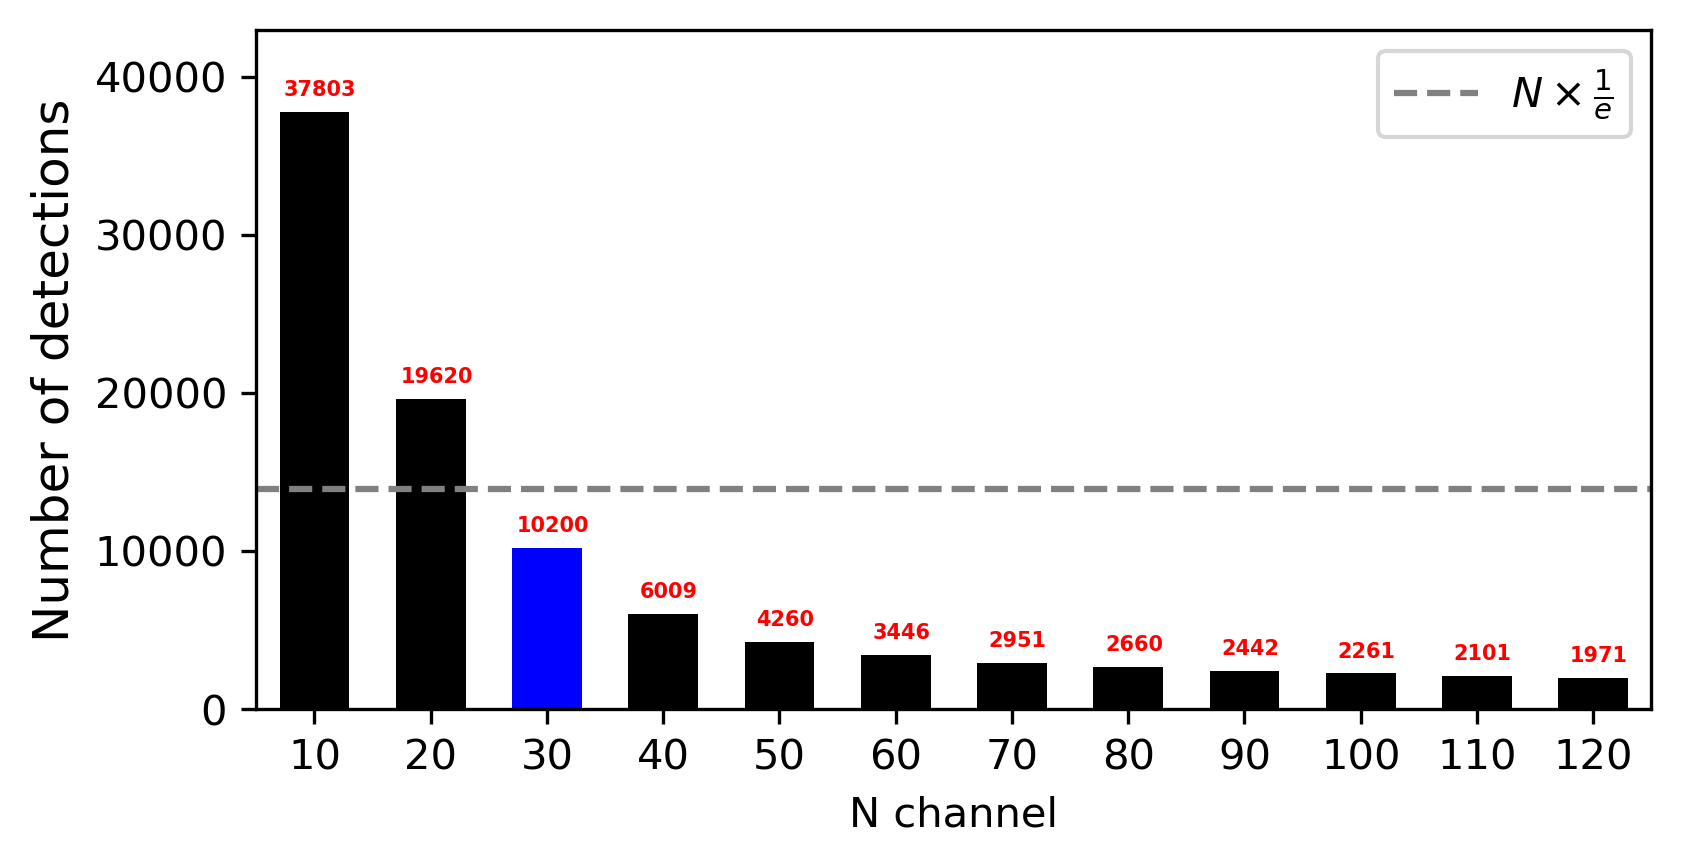

In [60]:
plt.figure(figsize=(6,3),dpi=300)
for i in range(0,len(ns),2):
    plt.bar(ns[i], counts[i],6,color='k')

    plt.text(ns[i]+0.5, counts[i]+1400, str(counts[i]), color='red', 
         fontweight='bold',fontsize=5,ha='center', va='center',rotation=0)
plt.bar(ns[4], counts[4],6,color='b')
# plt.plot(nss,one_tailed_normal(nss,a_fit, b_fit, c_fit, d_fit),lw=1,c='r',
#          label='Normal distribution fitting')
plt.hlines(counts[0]*1/np.e,5,125,linestyle='--',color='grey',label=r'$N \times \frac{1}{e}$')
# plt.yscale('log')
plt.legend()
plt.xlim(5,125)
plt.ylim(0,43000)
plt.xticks([10,20,30,40,50,60,70,80,90,100,110,120],[10,20,30,40,50,60,70,80,90,100,110,120])
plt.ylabel('Number of detections',fontsize=12)
plt.xlabel('N channel')

In [22]:
### matching with catalog, cal distances first

daslat=39.2633725374648 
daslon=142.144805409815
distances=[]
mag=[]
dep=[]
ind=[]
event_time=[]
lati=[]
long=[]
for i in range(len(latitude)):
    if isnan(latitude[i]) == False and isnan(longitude[i]) == False:
        distances.append(cal_dis(daslat,daslon,latitude[i],longitude[i]))
        lati.append(latitude[i])
        long.append(longitude[i])
        
        event_time.append(UTC(date[i])+3600*time[i].hour+60*time[i].minute+time[i].second+time[i].microsecond*0.000001)
        ind.append(index[i])
        
        if magnitude[i]!=magnitude[i]:
            mag.append('unknown')
        else:
            mag.append(magnitude[i])
            
        if depth[i]!=depth[i]:
            dep.append('unknown')
        else:
            dep.append(float(depth[i]))
            
hypo=[]
for i in range(len(distances)):
    hypo.append((distances[i]**2+dep[i]**2)**0.5)

In [8]:
# c=0
# for i in range(len(distances)):
#     if distances[i]<=1000:
#         c+=1
# c

4174

In [27]:
### cal theoretical travel time

model = cake.load_model('prem-no-ocean.m')

nonmag=[]
nondist=[]
nonindex=[]

for i in range(len(distances)):
    
    if distances[i]<=1000: 
        print(i)
        travel_time=[]
        phase=cake.PhaseDef.classic('S')
        arrivals=model.arrivals([distances[i]*1000*cake.m2d], phases=phase, zstart=dep[i]*1000, zstop=0)
        for arrival in arrivals:
            travel_time.append(arrival.t)

        phase=cake.PhaseDef.classic('s')
        arrivals=model.arrivals([distances[i]*1000*cake.m2d], phases=phase, zstart=dep[i]*1000, zstop=0)
        for arrival in arrivals:
            travel_time.append(arrival.t)

        if len(travel_time) == 0:
            print('event ',i,'doesnt have a computed travel time for s waves.')

        else:
            time_range=[ceil(event_time[i]+int(min(travel_time)-10)),ceil(event_time[i]+int(max(travel_time)+10))]
            matched=[]
            indexs=[]
            for tm in tm_detections:
                if time_range[0]<=tm<=time_range[1]:
                    matched.append(tm)
                    indexs.append(tm_detections.index(tm))

            if len(matched) == 0:
                nonmag.append(mag[i])
                nondist.append(hypo[i])
                nonindex.append(i)

0
1
2
3
4
5
6
7
8
9
11
12
13
14
15
16
17
18
19
20
21
22
24
25
26
27
28
29
31
32
33
34
35
37
38
41
42
43
46
47
48
49
50
52
54
60
61
62
63
64
65
66
68
70
71
73
74
75
76
77
78
80
84
85
88
89
90
91
92
93
97
98
99
100
101
103
105
107
108
109
111
112
115
116
118
120
121
122
123
126
127
129
130
131
132
133
134
135
136
137
138
139
142
143
144
145
146
151
152
153
154
156
157
160
161
162
164
165
166
167
169
170
174
175
176
177
179
180
181
182
183
184
185
186
187
188
190
191
192
193
194
198
201
203
204
205
207
208
210
211
213
215
216
217
218
219
222
223
224
227
229
230
231
232
233
234
237
240
241
242
243
244
246
247
248
249
250
251
252
253
256
257
258
260
261
263
264
265
266
267
268
269
271
272
273
277
279
280
281
282
283
284
286
287
288
289
291
292
294
296
297
298
300
301
303
304
305
306
307
308
310
311
313
314
315
317
318
322
323
324
326
328
331
334
335
336
338
339
340
341
342
344
346
347
348
349
350
351
353
354
358
359
360
362
363
364
365
366
367
368
369
371
373
374
376
377
379
381
382
383
384

2429
2431
2432
2433
2436
2437
2438
2439
2440
2441
2443
2444
2446
2448
2450
2451
2452
2454
2455
2456
2457
2458
2459
2460
2461
2462
2463
2465
2468
2469
2470
2471
2472
2473
2474
2475
2477
2478
2479
2480
2481
2482
2483
2484
2485
2486
2487
2488
2489
2490
2491
2492
2493
2494
2495
2496
2497
2498
2499
2500
2502
2503
2505
2506
2508
2510
2511
2512
2513
2515
2516
2517
2518
2521
2522
2523
2524
2525
2526
2527
2528
2529
2530
2531
2532
2534
2536
2537
2538
2540
2542
2543
2544
2545
2546
2551
2552
2554
2556
2557
2558
2559
2561
2562
2563
2564
2565
2567
2569
2570
2571
2572
2573
2574
2575
2577
2578
2579
2581
2582
2583
2584
2585
2587
2588
2589
2590
2592
2593
2594
2595
2597
2600
2601
2602
2604
2605
2606
2608
2609
2610
2611
2613
2615
2616
2617
2618
2619
2622
2623
2624
2625
2626
2627
2629
2630
2634
2635
2636
2637
2639
2642
2643
2644
2645
2646
2647
2650
2651
2652
2653
2654
2656
2657
2659
2660
2661
2662
2663
2675
2677
2678
2680
2681
2683
2684
2686
2688
2690
2691
2692
2693
2694
2695
2696
2697
2698
2699
2709
2710


4659
4660
4661
4663
4664
4665
4666
4667
4668
4669
4670
4671
4672
4673
4674
4675
4676
4677
4678
4679
4680
4681
4682
4683
4684
4685
4686
4687
4688
4689
4690
4692
4693
4694
4695
4696
4697
4698
4699
4703
4704
4705
4706
4709
4710
4711
4712
4713
4715
4717
4718
4719
4720
4721
4722
4724
4725
4726
4727
4728
4729
4730
4732
4733
4734
4735
4736
4739
4741
4742
4743
4744
4746
4747
4748
4749
4750
4751
4752
4753
4754
4755
4756
4757
4758
4759
4760
4761
4762
4763
4764
4765
4766
4768
4770
4771
4772
4773
4775
4776
4777
4778
4779
4780
4781
4782
4783
4784
4785
4786
4788
4789
4790
4791
4793
4794
4795
4796
4797
4798
4799
4800
4801
4802
4805
4807
4808
4809
4810
4811
4812
4813
4814
4815
4816
4817
4818
4819
4820
4821
4822
4823
4824
4826
4827
4828
4830
4831
4832
4833
4834
4835
4836
4837
4838
4839
4840
4841
4843
4844
4845
4846
4847
4848
4849
4850
4851
4852
4853
4854
4855
4856
4858
4859
4860
4861
4862
4863
4864
4865
4866
4867
4868
4869
4870
4871
4874
4875
4876
4878
4879
4880
4881
4882
4883
4884
4885
4886
4887
4888


In [29]:
## E=0.69*magnitude-1.588np.log10(hypo)+K
## K doesn't matter much though
B=np.pi*2/(100*3200)

In [32]:
### Jiuxun's amplitude threshold

recorded_mag=[]
recorded_dist=[]
recorded_index=[]
recorded_amp1=[]
recorded_amp2=[]

unrecorded_mag=[]
unrecorded_dist=[]
unrecorded_index=[]
unrecorded_amp1=[]
unrecorded_amp2=[]

for i in range(len(mag)):
    if i in nonindex:
        unrecorded_mag.append(mag[i])
        unrecorded_dist.append(hypo[i])
        unrecorded_index.append(i)
        unrecorded_amp1.append(0.69*mag[i]-1.588*np.log10(hypo[i]))
        unrecorded_amp2.append(10**mag[i]*(np.exp(-B*hypo[i])/hypo[i]**0.5))
    else:
        recorded_mag.append(mag[i])
        recorded_dist.append(hypo[i])
        recorded_index.append(i)
        recorded_amp1.append(0.69*mag[i]-1.588*np.log10(hypo[i])) 
        recorded_amp2.append(10**mag[i]*(np.exp(-B*hypo[i])/hypo[i]**0.5))

In [27]:
# plt.scatter(np.arange(len(recorded_amp2)),np.log10(recorded_amp2))
# plt.scatter(np.arange(len(unrecorded_amp2)),np.log10(unrecorded_amp2))
# plt.hlines(np.percentile(np.log10(unrecorded_amp2),90),0,3000,color='r')
# plt.show()

# plt.scatter(np.arange(len(recorded_amp1)),recorded_amp1)
# plt.scatter(np.arange(len(unrecorded_amp1)),unrecorded_amp1)
# plt.hlines(np.percentile(unrecorded_amp1,90),0,3000,color='r')

In [35]:
passed1=[]
passed2=[]
        
for i in range(len(hypo)):
    this_amp1=0.69*mag[i]-1.588*np.log10(hypo[i])
    if this_amp1>=np.percentile(unrecorded_amp1,90):
        passed1.append(i)
    this_amp2=10**mag[i]*(np.exp(-B*hypo[i])/hypo[i]**0.5)
    if this_amp2>=np.percentile(unrecorded_amp2,90):
        passed2.append(i)

In [36]:
### passed Yin amp thre, <=1000

c=0
for i in range(len(passed1)):
    if distances[passed1[i]]<=1000:
        c+=1
c

889

In [37]:
### amplitude threshold

for n in range(len(nondist)):
    if nondist[n]=='unknown':
        nonmag[n]=0
Q=np.percentile(unrecorded_amp1,90)

matched_mag=[]
unmatched_mag=[]
matched_dist=[]
unmatched_dist=[]
matched_ind=[]
unmatched_ind=[]

for i in range(len(distances)):
    print(i)
    travel_time=[]
    phase=cake.PhaseDef.classic('S')
    arrivals=model.arrivals([distances[i]*1000*cake.m2d], phases=phase, zstart=dep[i]*1000, zstop=0)
    for arrival in arrivals:
        travel_time.append(arrival.t)

    phase=cake.PhaseDef.classic('s')
    arrivals=model.arrivals([distances[i]*1000*cake.m2d], phases=phase, zstart=dep[i]*1000, zstop=0)
    for arrival in arrivals:
        travel_time.append(arrival.t)

    if len(travel_time) == 0:
        print('event ',i,'doesnt have a computed travel time for s waves.')

    else:
        time_range=[ceil(event_time[i]+int(min(travel_time)-10)),ceil(event_time[i]+int(max(travel_time)+10))]
        matched=[]
        indexs=[]
        for tm in tm_detections:
            if time_range[0]<=tm<=time_range[1]:
                matched.append(tm)
                indexs.append(tm_detections.index(tm))
                
        QA=0.69*mag[i]-1.588*np.log10(hypo[i])  
        
        if QA>=Q:
            if len(matched) >0:
                matched_mag.append(mag[i])
                matched_dist.append(distances[i])
                matched_ind.append(ind[i])
            
            else:
                unmatched_mag.append(mag[i])
                unmatched_dist.append(distances[i])
                unmatched_ind.append(ind[i])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060


3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700


5140
5141
5142
5143
5144
5145
5146
5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339


In [38]:
c=0
for i in range(len(matched_dist)):
    if matched_dist[i]<=1000:
        c+=1
c

599

In [39]:
selected_mag=[]
selected_depth=[]
selected_lat=[]
selected_lon=[]
unselected_mag=[]
unselected_depth=[]
unselected_lat=[]
unselected_lon=[]
daslat=39.2633725374648 
daslon=142.144805409815

for i in range(len(hypo)):
    if i in passed1 and distances[i] <=1000 :
        selected_mag.append(mag[i])
        selected_depth.append(dep[i])
        selected_lat.append(lati[i])
        selected_lon.append(long[i])
        
    elif i not in passed1 and distances[i] <=1000:
        unselected_mag.append(mag[i])
        unselected_depth.append(dep[i])
        unselected_lat.append(lati[i])
        unselected_lon.append(long[i])       

In [13]:
import obspy
import math
import glob
from obspy import UTCDateTime as UTC
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from math import sin, cos, sqrt, atan2, radians
from scipy import signal
from cartopy.io import shapereader
from PIL import Image
from scipy.interpolate import griddata
import cartopy
import cartopy.crs as ccrs
import pickle
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.img_tiles as tile
import pyproj
from matplotlib.patches import Patch,Circle
geodesic = pyproj.Geod(ellps='WGS84')
from matplotlib.offsetbox import AnchoredText

[Text(0, 30, '$30 ^\\circ$'),
 Text(0, 35, '$35 ^\\circ$'),
 Text(0, 40, '$40 ^\\circ$'),
 Text(0, 45, '$45 ^\\circ$'),
 Text(0, 50, '$50 ^\\circ$')]

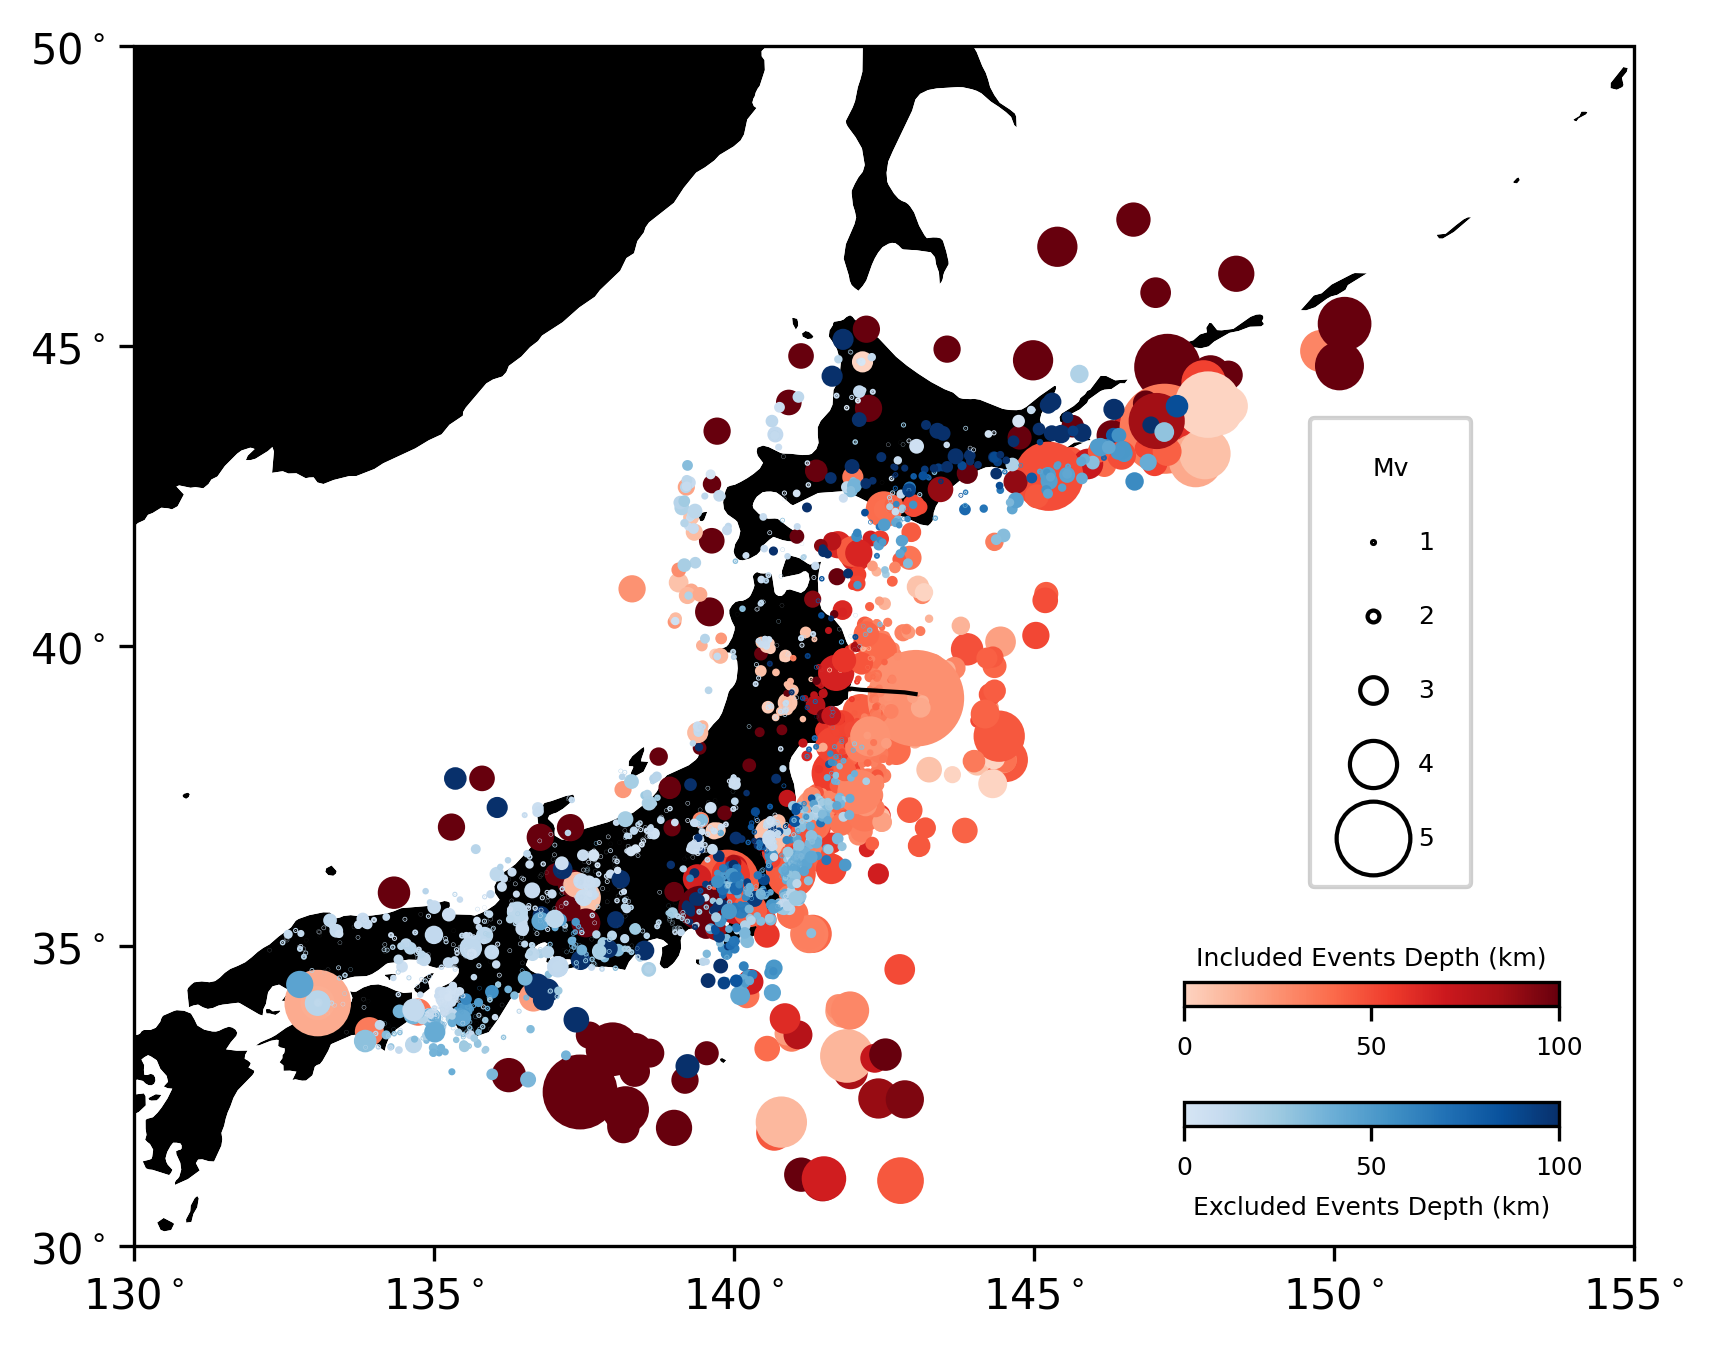

In [59]:
fig=plt.figure(figsize=(5,8))
fig.dpi=300
fig.subplots_adjust(hspace=0.1)

proj = cartopy.crs.PlateCarree()
ax3=fig.add_axes([0,0,1,1],projection=ccrs.PlateCarree())
ax3.set_xlim(130,155)
ax3.set_ylim(30,50)
# ax3.add_feature(cfeature.COASTLINE,edgecolor='black',lw=1)
ax3.add_feature(cfeature.LAND,facecolor='black')
ax3.add_feature(cfeature.OCEAN,facecolor='white')

ax3.plot(lons,lats,'k',lw=1)
sc1=ax3.scatter(selected_lon,selected_lat,marker='o',s=np.array(selected_mag)**4/2,
                c=np.array(selected_depth),cmap='Reds',vmin=-20,vmax=100)
sc2=ax3.scatter(unselected_lon,unselected_lat,marker='o',s=np.array(unselected_mag)**4/2,
                c=np.array(unselected_depth),cmap='Blues',vmin=-20,vmax=100)
cax1=fig.add_axes([0.7,0.35,0.25,0.01])
cbar1=fig.colorbar(sc1,cax=cax1,orientation='horizontal')
cbar1.ax.set_xlim(0,100)
cbar1.ax.set_xticks([0,50,100])
cbar1.ax.set_xticklabels([0,50,100],fontsize=6)
cbar1.ax.set_xlabel('Included Events Depth (km)',fontsize=6)
cbar1.ax.xaxis.set_label_position('top') 

cax2=fig.add_axes([0.7,0.3,0.25,0.01])
cbar2=fig.colorbar(sc2,cax=cax2,orientation='horizontal')
cbar2.ax.set_xlim(0,100)
cbar2.ax.set_xticks([0,50,100])
cbar2.ax.set_xticklabels([0,50,100],fontsize=6)
cbar2.ax.set_xlabel('Excluded Events Depth (km)',fontsize=6)

scatter2=ax3.scatter(80,180,marker='o',c='white',edgecolor='black',s=1**4/2,transform=ccrs.PlateCarree())
scatter3=ax3.scatter(80,180,marker='o',c='white',edgecolor='black',s=2**4/2,transform=ccrs.PlateCarree())
scatter4=ax3.scatter(80,180,marker='o',c='white',edgecolor='black',s=3**4/2,transform=ccrs.PlateCarree())
scatter5=ax3.scatter(80,180,marker='o',c='white',edgecolor='black',s=4**4/2,transform=ccrs.PlateCarree())
scatter6=ax3.scatter(80,180,marker='o',c='white',edgecolor='black',s=5**4/2,transform=ccrs.PlateCarree())
legend2=ax3.legend([scatter2,scatter3,scatter4,scatter5,scatter6],['1','2','3','4','5'],
                   borderpad=1.5,labelspacing=2,fontsize=6,loc='upper right',bbox_to_anchor=(0.9,0.7))
legend2.set_title('Mv')
legend2.get_title().set_fontsize('6')
ax3.add_artist(legend2)

xlocs=[130,135,140,145,150,155]
ylocs=[30,35,40,45,50]
ax3.set_xticks(xlocs)
ax3.set_yticks(ylocs)
ax3.set_xticklabels(labels=['$ %.0f ^\circ$' % x for x in xlocs], fontsize=10)
ax3.set_yticklabels(labels=['$%.0f ^\circ$' % y for y in ylocs], fontsize=10)


In [60]:
obdas_counterparts=[]

for match in matched_ind:
    
    i=ind.index(match)

    travel_time=[]
    phase=cake.PhaseDef.classic('S')
    arrivals=model.arrivals([distances[i]*1000*cake.m2d], phases=phase, zstart=dep[i]*1000, zstop=0)
    for arrival in arrivals:
        travel_time.append(arrival.t)

    phase=cake.PhaseDef.classic('s')
    arrivals=model.arrivals([distances[i]*1000*cake.m2d], phases=phase, zstart=dep[i]*1000, zstop=0)
    for arrival in arrivals:
        travel_time.append(arrival.t)

    if len(travel_time) == 0:
        print('event ',i,'doesnt have a computed travel time for s waves.')

    else:
        time_range=[ceil(event_time[i]+int(min(travel_time)-10)),ceil(event_time[i]+int(max(travel_time)+10))]
        matched=[]
        indexs=[]
        for tm in tm_detections:
            if time_range[0]<=tm<=time_range[1]:
                matched.append(tm)
                indexs.append(tm_detections.index(tm))
                
    obdas_counterparts.append(indexs)

In [61]:
### cataloged info

for i in range(len(obdas_counterparts)):
    
    info={}
    
    info['Event_index_JMA']=matched_ind[i]
    info['Event_time']=event_time[ind.index(matched_ind[i])]
    info['Magnitude']=matched_mag[i]
    info['Distance']=matched_dist[i]
    info['Latitude']=lati[ind.index(matched_ind[i])]
    info['Longitude']=long[ind.index(matched_ind[i])]
    info['Depth']=dep[ind.index(matched_ind[i])]
    info['Matched_index_OBDAS']=obdas_counterparts[i]
    
    times=[]
    matched_channels=[]
    for ob in obdas_counterparts[i]:
        times.append(float(UTC(tm_detections[ob])))
        matched_channels.extend(all_channel[ob])   
        
    info['Detection_time']=UTC(np.mean(times))
    info['Matched_channels']=list(np.sort(list(set(matched_channels))))
    
    if info['Distance']<=1000:
        foldername='/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/final_catalog_14s/WSS/cataloged_info/within1000/'
    else:
        foldername='/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/final_catalog_14s/WSS/cataloged_info/out1000/'
    
    filename=foldername+'OBDAS'+str(obdas_counterparts[i][0]).zfill(5)+'_JMA'+str(matched_ind[i]).zfill(4)+'.pkl'
#     if filename not in glob.glob(foldername+'*'):
#         print(filename)
    with open(filename, 'wb') as f:
        pickle.dump(info,f)

In [62]:
matched_OBDAS=[]
for ob in obdas_counterparts:
    matched_OBDAS.extend(ob)
matched_OBDAS=list(set(matched_OBDAS))

In [63]:
### uncataloged info

for i in range(len(tm_detections)):
    
    if i not in matched_OBDAS:
        
        info={}
        info['OBDAS_index']=i
        info['Detection_time']=tm_detections[i]
        info['Matched_channels']=all_channel[i]

        foldername='/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/final_catalog_14s/WSS/uncataloged_info/'
        filename=foldername+'OBDAS'+str(info['OBDAS_index']).zfill(5)+'.pkl'

        with open(filename, 'wb') as f:
            pickle.dump(info,f)

In [66]:
## WSS, uncataloged, master

infos=np.sort(glob.glob('/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/final_catalog_14s/WSS/uncataloged_info/*.pkl'))

uncataloged_file='/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/final_catalog_14s/WSS/uncataloged_file.txt'
uncataloged_f=open(uncataloged_file,'w+')

for i in range(len(infos)):
    
    with open(infos[i],'rb') as f:
        info=pickle.load(f)
        
    uncataloged_f.write('Detection index: '+str(info['OBDAS_index'])+'\n')
    uncataloged_f.write('Detection time: '+str(info['Detection_time'])+'\n') ## index
    uncataloged_f.write('Matched channel number: ') ## matched channels
    for ch in info['Matched_channels']:
        uncataloged_f.write(str(ch)+', ') ## matched channels
    uncataloged_f.write('\n')
    uncataloged_f.write(' \n') ## new line   

uncataloged_f.close()

In [67]:
## WSS, cataloged, master

infos1=glob.glob('/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/final_catalog_14s/WSS/cataloged_info/within1000/*.pkl')
infos2=glob.glob('/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/final_catalog_14s/WSS/cataloged_info/out1000/*.pkl')
infos=np.sort(infos1+infos2)

cataloged_file='/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/final_catalog_14s/WSS/cataloged_file.txt'
cataloged_f=open(cataloged_file,'w+')

for i in range(len(infos)):
    
    with open(infos[i],'rb') as f:
        info=pickle.load(f)

    cataloged_f.write('Event index: '+str(info['Event_index_JMA'])+'\n') ## index
    cataloged_f.write('event_time: '+str(info['Event_time'])+' ; ') ## detection time
    cataloged_f.write('magnitude: '+str(info['Magnitude'])+' ; ') 
    cataloged_f.write('latitude: '+str(info['Latitude'])+' ; ')
    cataloged_f.write('longitude: '+str(info['Longitude'])+' ; ')
    cataloged_f.write('distance: '+str(info['Distance'])+' ; ')
    cataloged_f.write('depth: '+str(info['Depth'])+' \n')

    cataloged_f.write('matchings: '+str(info['Matched_index_OBDAS'])+'\n') 
    cataloged_f.write('Detection_time: '+str(info['Detection_time'])+'\n') 

    
    for ch in info['Matched_channels']:
        cataloged_f.write(str(ch)+', ') ## matched channels
    cataloged_f.write('\n')
    cataloged_f.write(' \n') ## new line  

cataloged_f.close()

In [76]:
len(matched_mag)

605

In [90]:
### rates

def cal_rate(minmag,maxmag,mindist,maxdist):
    c=0
    cc=0
    for m in range(len(unmatched_mag)):

        if unmatched_mag[m]<=maxmag and unmatched_mag[m]>minmag:

            if unmatched_dist[m]<=maxdist and unmatched_dist[m]>=mindist:
                cc+=1

    for m in range(len(matched_mag)):
        if matched_mag[m]<=maxmag and matched_mag[m]>minmag:

            if matched_dist[m]<=maxdist and matched_dist[m]>=mindist:
                c+=1
    if cc+c>0:
        print(c,cc+c,c/(cc+c))
    else:
        print(c,cc+c)
        
mag_ranges=[[-0.1,2],[2,3],[3,4],[4,10],[-0.1,10]]
dist_ranges=[[0,100],[100,200],[200,500],[500,1000],[0,1000]]

# c=0
# for m in range(len(matched_mag)):
#     if matched_mag[m]<=10 and matched_mag[m]>=0:
#         c+=1
        
for mag_range in mag_ranges:
        
    for dist_range in dist_ranges:
        
        print(mag_range,dist_range)
        print(cal_rate(mag_range[0],mag_range[1],dist_range[0],dist_range[1]))
        print(' ')

[-0.1, 2] [0, 100]
235 293 0.8020477815699659
None
 
[-0.1, 2] [100, 200]
100 173 0.5780346820809249
None
 
[-0.1, 2] [200, 500]
36 105 0.34285714285714286
None
 
[-0.1, 2] [500, 1000]
0 0
None
 
[-0.1, 2] [0, 1000]
371 571 0.649737302977233
None
 
[2, 3] [0, 100]
22 22 1.0
None
 
[2, 3] [100, 200]
35 36 0.9722222222222222
None
 
[2, 3] [200, 500]
83 122 0.680327868852459
None
 
[2, 3] [500, 1000]
29 59 0.4915254237288136
None
 
[2, 3] [0, 1000]
169 239 0.7071129707112971
None
 
[3, 4] [0, 100]
6 6 1.0
None
 
[3, 4] [100, 200]
5 5 1.0
None
 
[3, 4] [200, 500]
18 21 0.8571428571428571
None
 
[3, 4] [500, 1000]
19 35 0.5428571428571428
None
 
[3, 4] [0, 1000]
48 67 0.7164179104477612
None
 
[4, 10] [0, 100]
1 1 1.0
None
 
[4, 10] [100, 200]
0 0
None
 
[4, 10] [200, 500]
2 2 1.0
None
 
[4, 10] [500, 1000]
10 11 0.9090909090909091
None
 
[4, 10] [0, 1000]
13 14 0.9285714285714286
None
 
[-0.1, 10] [0, 100]
264 322 0.8198757763975155
None
 
[-0.1, 10] [100, 200]
140 214 0.6542056074766355
N

# SSS

In [93]:
### SSS info

sss_file='/nfs/turbo/lsa-zspica/work/yaolinm/working_notebooks/Japan/all_SSS_detections.txt'
sss_detections=[]
f=open(sss_file,'r')
lines=f.readlines()
for line in lines:
    sss_detections.append(UTC(line.strip()))

In [41]:
passed=[]

for i in range(len(hypo)):
    this_amp1=0.69*mag[i]-1.588*np.log10(hypo[i])
    if this_amp1>=-2.7680847517985727:
        passed.append(i)

In [94]:
model = cake.load_model('prem-no-ocean.m')

sss_matched_mag=[]
sss_matched_ind=[]
sss_matched_dist=[]
matched_obdas_index=[]

sss_unmatched_mag=[]
sss_unmatched_ind=[]
sss_unmatched_dist=[]
unmatched_obdas_index=[]

for i in range(len(distances)):
    
    if i in passed:
        
        travel_time=[]
        phase=cake.PhaseDef.classic('S')
        arrivals=model.arrivals([distances[i]*1000*cake.m2d], phases=phase, zstart=dep[i]*1000, zstop=0)
        for arrival in arrivals:
            travel_time.append(arrival.t)

        phase=cake.PhaseDef.classic('s')
        arrivals=model.arrivals([distances[i]*1000*cake.m2d], phases=phase, zstart=dep[i]*1000, zstop=0)
        for arrival in arrivals:
            travel_time.append(arrival.t)

        if len(travel_time) == 0:
            print('event ',i,'doesnt have a computed travel time for s waves.')

        else:
            time_range=[ceil(event_time[i]+int(min(travel_time)-15)),ceil(event_time[i]+int(max(travel_time)+15))]
            matched=[]
            indexs=[]
            for sss in sss_detections:
                if time_range[0]<=sss<=time_range[1]:
                    matched.append(sss)
                    indexs.append(sss_detections.index(sss))


            if len(matched) >0:
                sss_matched_mag.append(mag[i])
                sss_matched_dist.append(distances[i])
                sss_matched_ind.append(ind[i])
                matched_obdas_index.append(indexs)
            else:
                
                sss_unmatched_mag.append(mag[i])
                sss_unmatched_ind.append(ind[i])
                sss_unmatched_dist.append(distances[i])
                unmatched_obdas_index.append(indexs)
                

In [97]:
channel_thre=np.load('/nfs/turbo/lsa-zspica/work/yaolinm/working_notebooks/Japan/channel_thre3.npy')
def locate_sss_event(event_time):
    
    file_ind=int((event_time-(obspy.UTCDateTime('2019-11-20T00:00:24.62995')+9*3600))//3600)

    df=np.load('/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/coherence_test/all_channel_stacked/'+str(file_ind).zfill(3)+'hr_stacked.npy')
    col_ind=int((event_time-(obspy.UTCDateTime('2019-11-20T00:00:24.62995')+9*3600)-file_ind*3600-20)//4-1)               
    
    return df[:,col_ind] 
#     return col_ind

In [101]:
### cataloged info, SSS

for i in range(len(sss_matched_ind)):
    print(i)
    
    info={}
    
    info['Event_index_JMA']=sss_matched_ind[i]
    info['Event_time']=event_time[ind.index(sss_matched_ind[i])]
    info['Magnitude']=sss_matched_mag[i]
    info['Distance']=sss_matched_dist[i]
    info['Latitude']=lati[ind.index(sss_matched_ind[i])]
    info['Longitude']=long[ind.index(sss_matched_ind[i])]
    info['Depth']=dep[ind.index(sss_matched_ind[i])]
    info['Matched_index_OBDAS_SSS']=matched_obdas_index[i][0]
    
#     times=[]
#     matched_channels=[]
#     for ob in obdas_counterparts[i]:
#         times.append(float(UTC(tm_detections[ob])))
#         matched_channels.extend(all_channel[ob])   
        
    chs=[]
    eq_coh=locate_sss_event(sss_detections[matched_obdas_index[i][0]])
    for j in range(300,9599):
        if eq_coh[j] >= channel_thre[j]:
            chs.append(j)
            c+=1
        
    info['Detection_time']=sss_detections[matched_obdas_index[i][0]]
    info['Matched_channels']=chs
    
    if info['Distance']<=1000:
        foldername='/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/final_catalog_14s/SSS/cataloged_info/within1000/'
    else:
        foldername='/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/final_catalog_14s/SSS/cataloged_info/out1000/'
    
    filename=foldername+'OBDAS'+str(matched_obdas_index[i][0]).zfill(5)+'_JMA'+str(sss_matched_ind[i]).zfill(4)+'.pkl'
    
    with open(filename, 'wb') as f:
        pickle.dump(info,f)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [102]:
sss_matched_OBDAS=[]
for ob in matched_obdas_index:
    sss_matched_OBDAS.extend(ob)
sss_matched_OBDAS=list(np.sort(list(set(sss_matched_OBDAS))))

In [103]:
### uncataloged info, SSS

for i in range(len(sss_detections)):
    print(i)
    
    if i not in sss_matched_OBDAS:
        
        info={}
        info['OBDAS_index']=i
        info['Detection_time']=sss_detections[i]
        
        chs=[]
        eq_coh=locate_sss_event(sss_detections[i])
        for j in range(300,9599):
            if eq_coh[j] >= channel_thre[j]:
                chs.append(j)
                c+=1
        info['Matched_channels']=chs

        foldername='/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/final_catalog_14s/SSS/uncataloged_info/'
        filename=foldername+'OBDAS'+str(info['OBDAS_index']).zfill(5)+'.pkl'

        with open(filename, 'wb') as f:
            pickle.dump(info,f)      

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065


3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590


In [104]:
## SSS, cataloged, master

infos1=glob.glob('/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/final_catalog_14s/SSS/cataloged_info/within1000/*.pkl')
infos2=glob.glob('/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/final_catalog_14s/SSS/cataloged_info/out1000/*.pkl')
infos=np.sort(infos1+infos2)

cataloged_file='/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/final_catalog_14s/SSS/cataloged_file.txt'
cataloged_f=open(cataloged_file,'w+')

for i in range(len(infos)):
    
    with open(infos[i],'rb') as f:
        info=pickle.load(f)

    cataloged_f.write('Event index: '+str(info['Event_index_JMA'])+'\n') ## index
    cataloged_f.write('event_time: '+str(info['Event_time'])+' ; ') ## detection time
    cataloged_f.write('magnitude: '+str(info['Magnitude'])+' ; ') 
    cataloged_f.write('latitude: '+str(info['Latitude'])+' ; ')
    cataloged_f.write('longitude: '+str(info['Longitude'])+' ; ')
    cataloged_f.write('distance: '+str(info['Distance'])+' ; ')
    cataloged_f.write('depth: '+str(info['Depth'])+' \n')

    cataloged_f.write('matchings: '+str(info['Matched_index_OBDAS_SSS'])+'\n') 
    cataloged_f.write('Detection_time: '+str(info['Detection_time'])+'\n') 

    
    for ch in info['Matched_channels']:
        cataloged_f.write(str(ch)+', ') ## matched channels
    cataloged_f.write('\n')
    cataloged_f.write(' \n') ## new line  

cataloged_f.close()

In [105]:
## SSS, uncataloged, master

infos=np.sort(glob.glob('/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/final_catalog_14s/SSS/uncataloged_info/*.pkl'))

uncataloged_file='/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/final_catalog_14s/SSS/uncataloged_file.txt'
uncataloged_f=open(uncataloged_file,'w+')

for i in range(len(infos)):
    
    with open(infos[i],'rb') as f:
        info=pickle.load(f)
        
    uncataloged_f.write('Detection index: '+str(info['OBDAS_index'])+'\n')
    uncataloged_f.write('Detection time: '+str(info['Detection_time'])+'\n') ## index
    uncataloged_f.write('Matched channel number: ') ## matched channels
    for ch in info['Matched_channels']:
        uncataloged_f.write(str(ch)+', ') ## matched channels
    uncataloged_f.write('\n')
    uncataloged_f.write(' \n') ## new line   

uncataloged_f.close()

In [107]:
def sss_cal_rate(minmag,maxmag,mindist,maxdist):
    c=0
    cc=0
    for m in range(len(sss_unmatched_mag)):

        if sss_unmatched_mag[m]<=maxmag and sss_unmatched_mag[m]>minmag:

            if sss_unmatched_dist[m]<=maxdist and sss_unmatched_dist[m]>=mindist:
                cc+=1

    for m in range(len(sss_matched_mag)):
        if sss_matched_mag[m]<=maxmag and sss_matched_mag[m]>minmag:

            if sss_matched_dist[m]<=maxdist and sss_matched_dist[m]>=mindist:
                c+=1
                
    if cc+c>0:
        print(c,cc+c,round(c/(cc+c),3))
    else:
        print(c,cc+c)
        
for mag_range in mag_ranges:
        
    for dist_range in dist_ranges:
        
        print(mag_range,dist_range)
        print(sss_cal_rate(mag_range[0],mag_range[1],dist_range[0],dist_range[1]))
        print(' ')

[-0.1, 2] [0, 100]
106 293 0.362
None
 
[-0.1, 2] [100, 200]
50 173 0.289
None
 
[-0.1, 2] [200, 500]
22 105 0.21
None
 
[-0.1, 2] [500, 1000]
0 0
None
 
[-0.1, 2] [0, 1000]
178 571 0.312
None
 
[2, 3] [0, 100]
9 22 0.409
None
 
[2, 3] [100, 200]
23 36 0.639
None
 
[2, 3] [200, 500]
54 122 0.443
None
 
[2, 3] [500, 1000]
21 59 0.356
None
 
[2, 3] [0, 1000]
107 239 0.448
None
 
[3, 4] [0, 100]
5 6 0.833
None
 
[3, 4] [100, 200]
5 5 1.0
None
 
[3, 4] [200, 500]
18 21 0.857
None
 
[3, 4] [500, 1000]
19 35 0.543
None
 
[3, 4] [0, 1000]
47 67 0.701
None
 
[4, 10] [0, 100]
1 1 1.0
None
 
[4, 10] [100, 200]
0 0
None
 
[4, 10] [200, 500]
1 2 0.5
None
 
[4, 10] [500, 1000]
5 11 0.455
None
 
[4, 10] [0, 1000]
7 14 0.5
None
 
[-0.1, 10] [0, 100]
121 322 0.376
None
 
[-0.1, 10] [100, 200]
78 214 0.364
None
 
[-0.1, 10] [200, 500]
95 250 0.38
None
 
[-0.1, 10] [500, 1000]
45 105 0.429
None
 
[-0.1, 10] [0, 1000]
339 891 0.38
None
 


# Master and plots

In [43]:
wss_infos=np.sort(glob.glob('/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/final_catalog_14s/WSS/cataloged_info/within1000/*')+glob.glob('/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/final_catalog_14s/WSS/cataloged_info/out1000/*'))
sss_infos=np.sort(glob.glob('/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/final_catalog_14s/SSS/cataloged_info/within1000/*')+glob.glob('/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/final_catalog_14s/SSS/cataloged_info/out1000/*'))
matched_ind=[]
sss_matched_ind=[]

for info in wss_infos:
    with open(info,'rb') as f:
        infodic=pickle.load(f)
        matched_ind.append(infodic['Event_index_JMA'])

for info in sss_infos:
    with open(info,'rb') as f:
        infodic=pickle.load(f)
        sss_matched_ind.append(infodic['Event_index_JMA'])        

In [44]:
### fs9

header=['Index','Date','Time','Latitude','Longitude','Depth','Magnitude','Epi-distance','WSS','SSS']
with open('/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/final_catalog_14s/passed_events_newnew.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(header)
    for ide in passed:
        if ind[ide] in matched_ind:
            wsse=1
        else:
            wsse=0
        if ind[ide] in sss_matched_ind:
            ssse=1
        else:
            ssse=0
        data=[ind[ide],str(event_time[ide].date),str(event_time[ide].time),
             lati[ide],long[ide],dep[ide],mag[ide],distances[ide],wsse,ssse]
        writer.writerow(data)

In [4]:
dframe=pd.read_csv('/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/final_catalog_14s/passed_events_newnew.csv')
eindex=dframe['Index']
magnitude=dframe['Magnitude']
latitude=dframe['Latitude']
longitude=dframe['Longitude']
distance=dframe['Epi-distance']
wsss=dframe['WSS']
ssss=dframe['SSS']

In [74]:
lati1=37
lati2=42
long1=139
long2=145

daslat=39.2633725374648 
daslon=142.144805409815

lon100=[]
lat100=[]
lon200=[]
lat200=[]

for az in range(0,360):
    newlon,newlat,_ = geodesic.fwd(daslon, daslat, az, 100*1000)
    lon100.append(newlon)
    lat100.append(newlat)
    newlon,newlat,_ = geodesic.fwd(daslon, daslat, az, 200*1000)
    lon200.append(newlon)
    lat200.append(newlat)

In [75]:
long_detected=[]
lati_detected=[]
mag_detected=[]
long_ndetected=[]
lati_ndetected=[]
mag_ndetected=[]
clong_detected=[]
clati_detected=[]
cmag_detected=[]
clong_ndetected=[]
clati_ndetected=[]
cmag_ndetected=[]

for i in range(len(wsss)):
    if distance[i]<=250:
        if wsss[i]==1 or eindex[i]==3856:
            long_detected.append(longitude[i])
            lati_detected.append(latitude[i])
            mag_detected.append(max(magnitude[i]**4/4,0.25))
        else:
            long_ndetected.append(longitude[i])
            lati_ndetected.append(latitude[i])
            mag_ndetected.append(max(magnitude[i]**4/4,0.25))

        if ssss[i]==1:
            clong_detected.append(longitude[i])
            clati_detected.append(latitude[i])
            cmag_detected.append(max(magnitude[i]**4/4,0.25))
        else:
            clong_ndetected.append(longitude[i])
            clati_ndetected.append(latitude[i])
            cmag_ndetected.append(max(magnitude[i]**4/4,0.25))

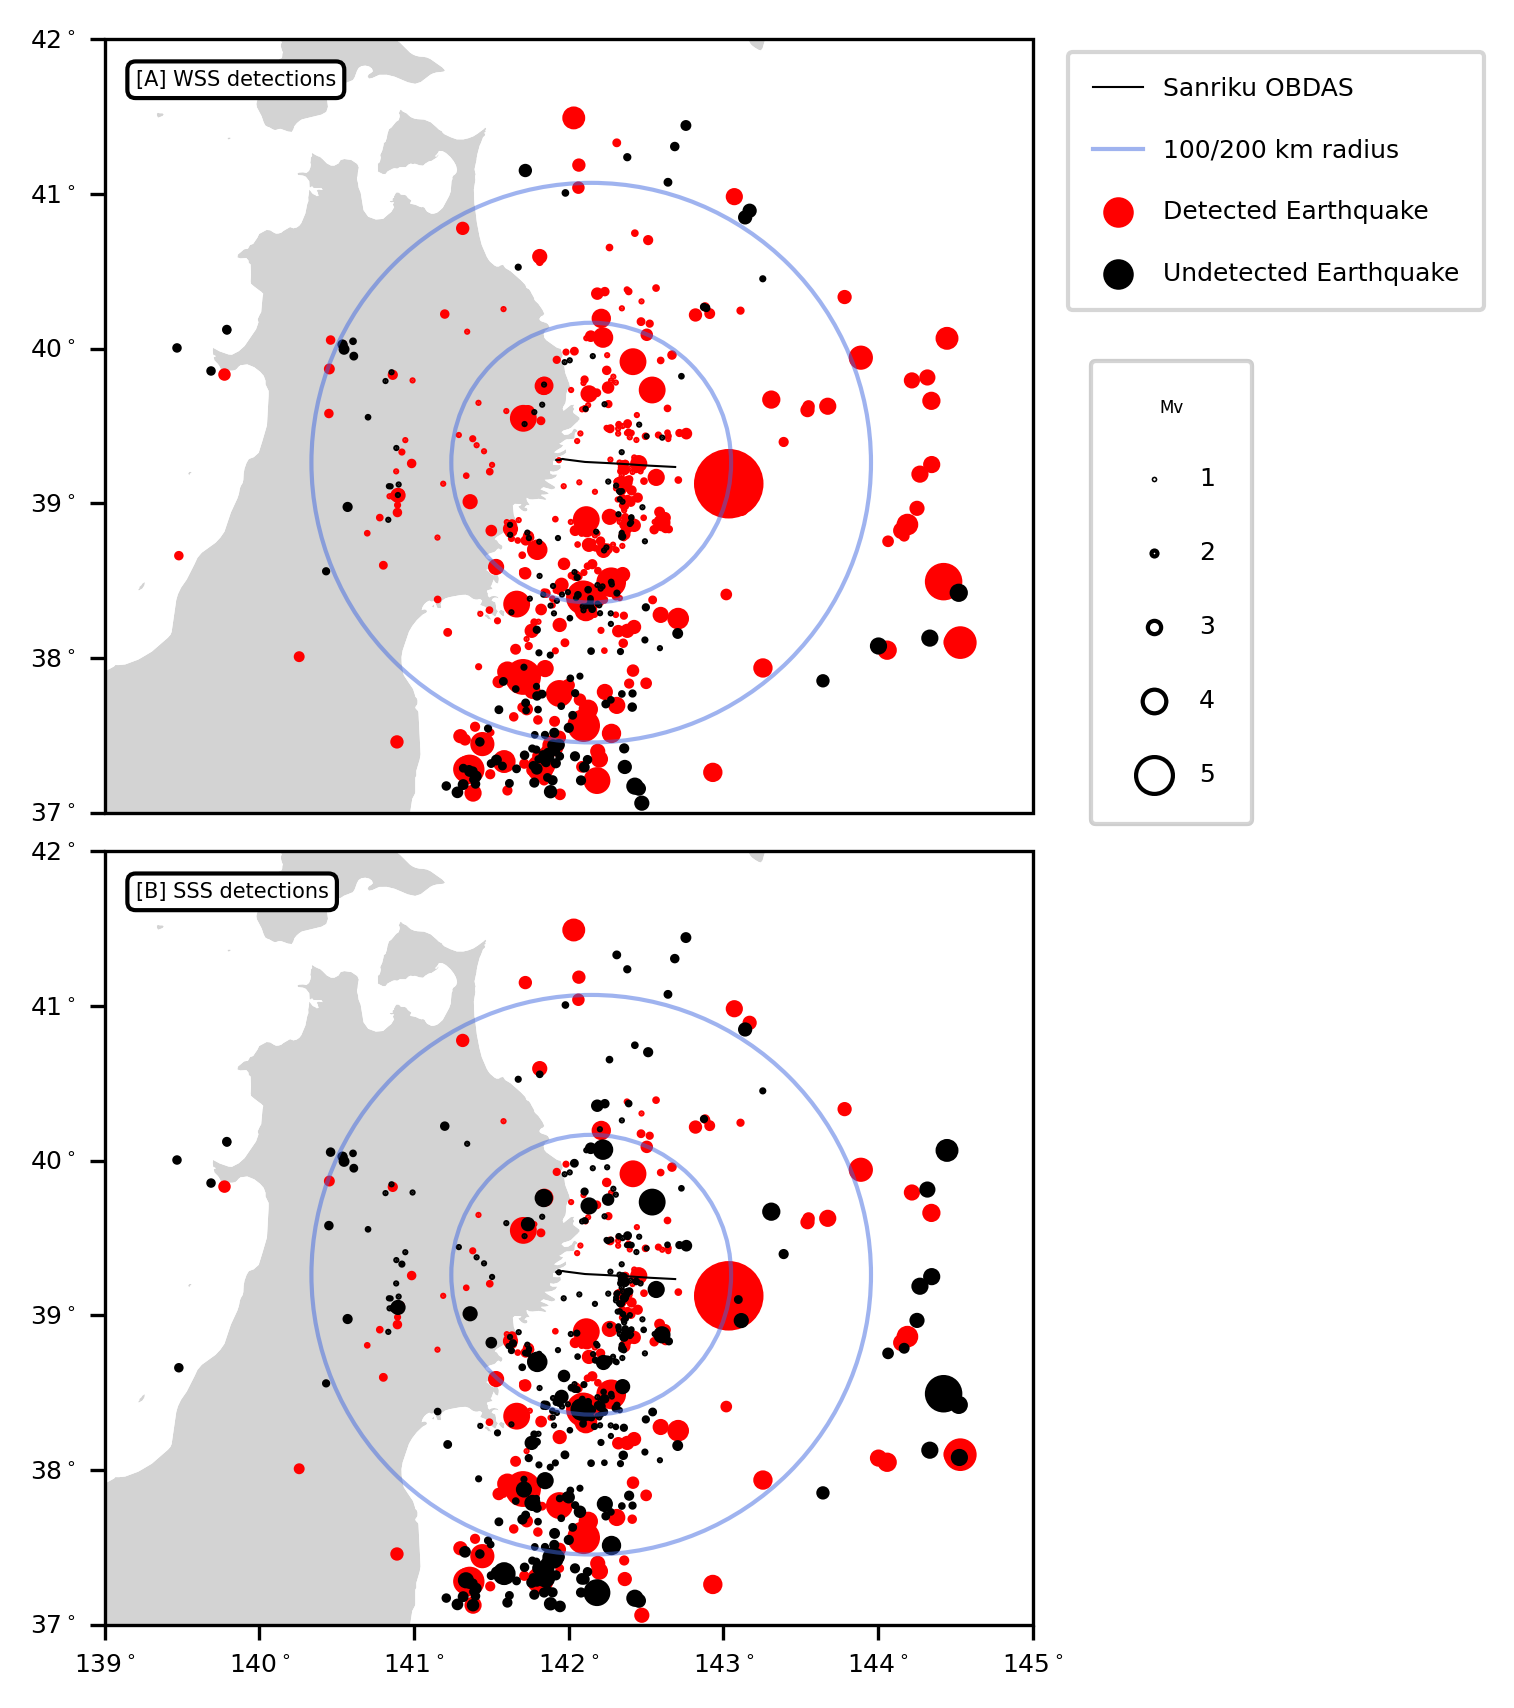

In [119]:
### F8

xlocs=[139,140,141,142,143,144,145]
ylocs=[37,38,39,40,41,42]

fig=plt.figure(figsize=(7,7),dpi=300)
fig.subplots_adjust(hspace=0.05,wspace=0)
proj = cartopy.crs.PlateCarree()

ax1 = fig.add_subplot(211, projection=proj)
ax1.set_xlim((long1, long2))
ax1.set_ylim((lati1, lati2))
ax1.text(139.2,41.7,'[A] WSS detections',bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.4'),c='k',fontsize=5)

ax1.add_feature(cfeature.LAND,facecolor='lightgrey')
ax1.add_feature(cfeature.OCEAN,facecolor='white')

ax1.plot(lons[:13722],lats[:13722], c='k',zorder=6,linewidth=0.5,label='Sanriku OBDAS')
ax1.add_patch(Circle(xy=[daslon,daslat], radius =100/110.574,fill=False, zorder=30,ec='royalblue',
                     alpha=0.5,transform=cartopy.crs.PlateCarree()))
ax1.add_patch(Circle(xy=[daslon,daslat], radius =200/110.574,fill=False, zorder=30,ec='royalblue',
                     alpha=0.5,transform=cartopy.crs.PlateCarree()))
ax1.plot(10,10,c='royalblue',alpha=0.5,zorder=1,lw=1,label='100/200 km radius')

ax1.scatter(long_detected,lati_detected,marker='o',c='red',edgecolor='red',s=mag_detected,transform=cartopy.crs.PlateCarree(),zorder=5)
ax1.scatter(long_ndetected,lati_ndetected,marker='o',c='k',edgecolor='k',s=mag_ndetected,transform=cartopy.crs.PlateCarree(),zorder=5)

ax1.scatter(0,0,marker='o',color='red',s=40,transform=ccrs.PlateCarree(),label='Detected Earthquake')
ax1.scatter(0,0,marker='o',color='black',s=40,transform=ccrs.PlateCarree(),label='Undetected Earthquake')
ax1.legend(borderpad=1,labelspacing=1.5,fontsize=6,loc='upper right',bbox_to_anchor=(1.5,1))

# ax1.set_xticks([139,140,141,142,143,144,145])
# ax1.set_xticklabels(['','','','','','',''])
# ax1.set_yticks([37,38,39,40,41,42])
# ax1.set_yticklabels([37,38,39,40,41,42], fontsize=6)
# ax1.set_ylabel("Laitude ($^{\circ}$)", fontsize=9)
ax1.set_yticks(ylocs)
ax1.set_yticklabels(labels=['$%.0f ^\circ$' % y for y in ylocs], fontsize=6)


###second

ax2 = fig.add_subplot(212, projection=proj)
ax2.set_xlim((long1, long2))
ax2.set_ylim((lati1, lati2))
ax2.text(139.2,41.7,'[B] SSS detections',bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.4'),c='k',fontsize=5)

ax2.add_feature(cfeature.LAND,facecolor='lightgrey')
ax2.add_feature(cfeature.OCEAN,facecolor='white')

ax2.plot(lons[:13722],lats[:13722], c='k',zorder=6,linewidth=0.5)
ax2.add_patch(Circle(xy=[daslon,daslat], radius =100/110.574,fill=False, zorder=30,ec='royalblue',
                     alpha=0.5,transform=cartopy.crs.PlateCarree()))
ax2.add_patch(Circle(xy=[daslon,daslat], radius =200/110.574,fill=False, zorder=30,ec='royalblue',
                     alpha=0.5,transform=cartopy.crs.PlateCarree()))


ax2.scatter(clong_detected,clati_detected,marker='o',c='red',edgecolor='red',s=cmag_detected,transform=cartopy.crs.PlateCarree(),zorder=5)
ax2.scatter(clong_ndetected,clati_ndetected,marker='o',c='k',edgecolor='k',s=cmag_ndetected,transform=cartopy.crs.PlateCarree(),zorder=5)

# ax2.set_xticks([139,140,141,142,143,144,145])
# ax2.set_xticklabels([139,140,141,142,143,144,145], fontsize=6)

ax2.set_xticks(xlocs)
ax2.set_yticks(ylocs)
ax2.set_xticklabels(labels=['$ %.0f ^\circ$' % x for x in xlocs], fontsize=6)
ax2.set_yticklabels(labels=['$%.0f ^\circ$' % y for y in ylocs], fontsize=6)
# ax2.set_xlabel("Longitude ($^{\circ}$)", fontsize=9)
# ax2.set_yticks([37,38,39,40,41,42])
# ax2.set_yticklabels([37,38,39,40,41,42], fontsize=6)
# ax2.set_ylabel("Laitude ($^{\circ}$)", fontsize=9)

scatter2=plt.scatter(80,180,marker='o',c='white',edgecolor='black',s=1**4/8,transform=ccrs.PlateCarree())
scatter3=plt.scatter(80,180,marker='o',c='white',edgecolor='black',s=2**4/8,transform=ccrs.PlateCarree())
scatter4=plt.scatter(80,180,marker='o',c='white',edgecolor='black',s=3**4/8,transform=ccrs.PlateCarree())
scatter5=plt.scatter(80,180,marker='o',c='white',edgecolor='black',s=4**4/8,transform=ccrs.PlateCarree())
scatter6=plt.scatter(80,180,marker='o',c='white',edgecolor='black',s=5**4/8,transform=ccrs.PlateCarree())
legend2=plt.legend([scatter2,scatter3,scatter4,scatter5,scatter6],['1','2','3','4','5'],
                   borderpad=1.5,labelspacing=2,fontsize=6,loc='upper right',bbox_to_anchor=(1.25,1.65))
legend2.set_title('Mv')
legend2.get_title().set_fontsize('4')
plt.gca().add_artist(legend2)

# plt.savefig('event_map_large.png',dpi=300, bbox_inches = 'tight')

In [14]:
cataloged_wss=np.zeros(9600)
cataloged_sss=np.zeros(9600)
all_wss=np.zeros(9600)
all_sss=np.zeros(9600)

infos1=glob.glob('/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/final_catalog_14s/WSS/cataloged_info/within1000/*.pkl')
infos2=glob.glob('/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/final_catalog_14s/WSS/cataloged_info/out1000/*.pkl')
infos=np.sort(infos1+infos2)
for info in infos:
    
    with open(info,'rb') as f:
        infodic=pickle.load(f)
    cataloged_wss[np.array(infodic['Matched_channels'])]+=1
    all_wss[np.array(infodic['Matched_channels'])]+=1
        
infos=glob.glob('/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/final_catalog_14s/WSS/uncataloged_info/*.pkl')
for info in infos:
    with open(info,'rb') as f:
        infodic=pickle.load(f)
    all_wss[np.array(infodic['Matched_channels'])]+=1
        
infos1=glob.glob('/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/final_catalog_14s/SSS/cataloged_info/within1000/*.pkl')
infos2=glob.glob('/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/final_catalog_14s/SSS/cataloged_info/out1000/*.pkl')
infos=np.sort(infos1+infos2)
for info in infos:
    with open(info,'rb') as f:
        infodic=pickle.load(f)
    cataloged_sss[np.array(infodic['Matched_channels'])]+=1
    all_sss[np.array(infodic['Matched_channels'])]+=1
    
infos=glob.glob('/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/final_catalog_14s/SSS/uncataloged_info/*.pkl')
for info in infos:
    with open(info,'rb') as f:
        infodic=pickle.load(f)
    all_sss[np.array(infodic['Matched_channels'])]+=1

In [137]:
sec1_mag=[]
sec1_dist=[]
sec1_dep=[]
sec2_mag=[]
sec2_dist=[]
sec2_dep=[]
sec3_mag=[]
sec3_dist=[]
sec3_dep=[]

infos1=glob.glob('/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/final_catalog_14s/WSS/cataloged_info/within1000/*.pkl')
infos2=glob.glob('/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/final_catalog_14s//WSS/cataloged_info/out1000/*.pkl')
infos=np.sort(infos1+infos2)

for info in infos:
    with open(info,'rb') as f:
        infodic=pickle.load(f)
        
        if infodic['Distance'] <=1000 and infodic['Depth'] <=200:
            chs=infodic['Matched_channels']
            
            for k in range(400,600):
                if k in chs:
                    sec1_mag.append(infodic['Magnitude'])
                    sec1_dist.append(infodic['Distance'])
                    sec1_dep.append(infodic['Depth'])
                    break

            for k in range(1400,1600):
                if k in chs:
                    sec2_mag.append(infodic['Magnitude'])
                    sec2_dist.append(infodic['Distance'])
                    sec2_dep.append(infodic['Depth'])
                    break
                    
            for k in range(9000,9200):
                if k in chs:
                    sec3_mag.append(infodic['Magnitude'])
                    sec3_dist.append(infodic['Distance'])
                    sec3_dep.append(infodic['Depth'])
                    break
                    
infos1=glob.glob('/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/final_catalog_14s/SSS/cataloged_info/within1000/*.pkl')
infos2=glob.glob('/nfs/turbo/lsa-zspica/work/yaolinm/Japan_detection/final_catalog_14s/SSS/cataloged_info/out1000/*.pkl')
infos=np.sort(infos1+infos2)

for info in infos:
    with open(info,'rb') as f:
        infodic=pickle.load(f)
        
        if infodic['Distance'] <=1000 and infodic['Depth'] <=200:
            chs=infodic['Matched_channels']
            
            for k in range(400,600):
                if k in chs:
                    sec1_mag.append(infodic['Magnitude'])
                    sec1_dist.append(cal_dis(lats[k],lons[k],infodic['Latitude'],infodic['Longitude']))
                    sec1_dep.append(infodic['Depth'])
                    break

            for k in range(1400,1600):
                if k in chs:
                    sec2_mag.append(infodic['Magnitude'])
                    sec2_dist.append(cal_dis(lats[k],lons[k],infodic['Latitude'],infodic['Longitude']))
                    sec2_dep.append(infodic['Depth'])
                    break
                    
            for k in range(9000,9200):
                if k in chs:
                    sec3_mag.append(infodic['Magnitude'])
                    sec3_dist.append(cal_dis(lats[k],lons[k],infodic['Latitude'],infodic['Longitude']))
                    sec3_dep.append(infodic['Depth'])
                    break

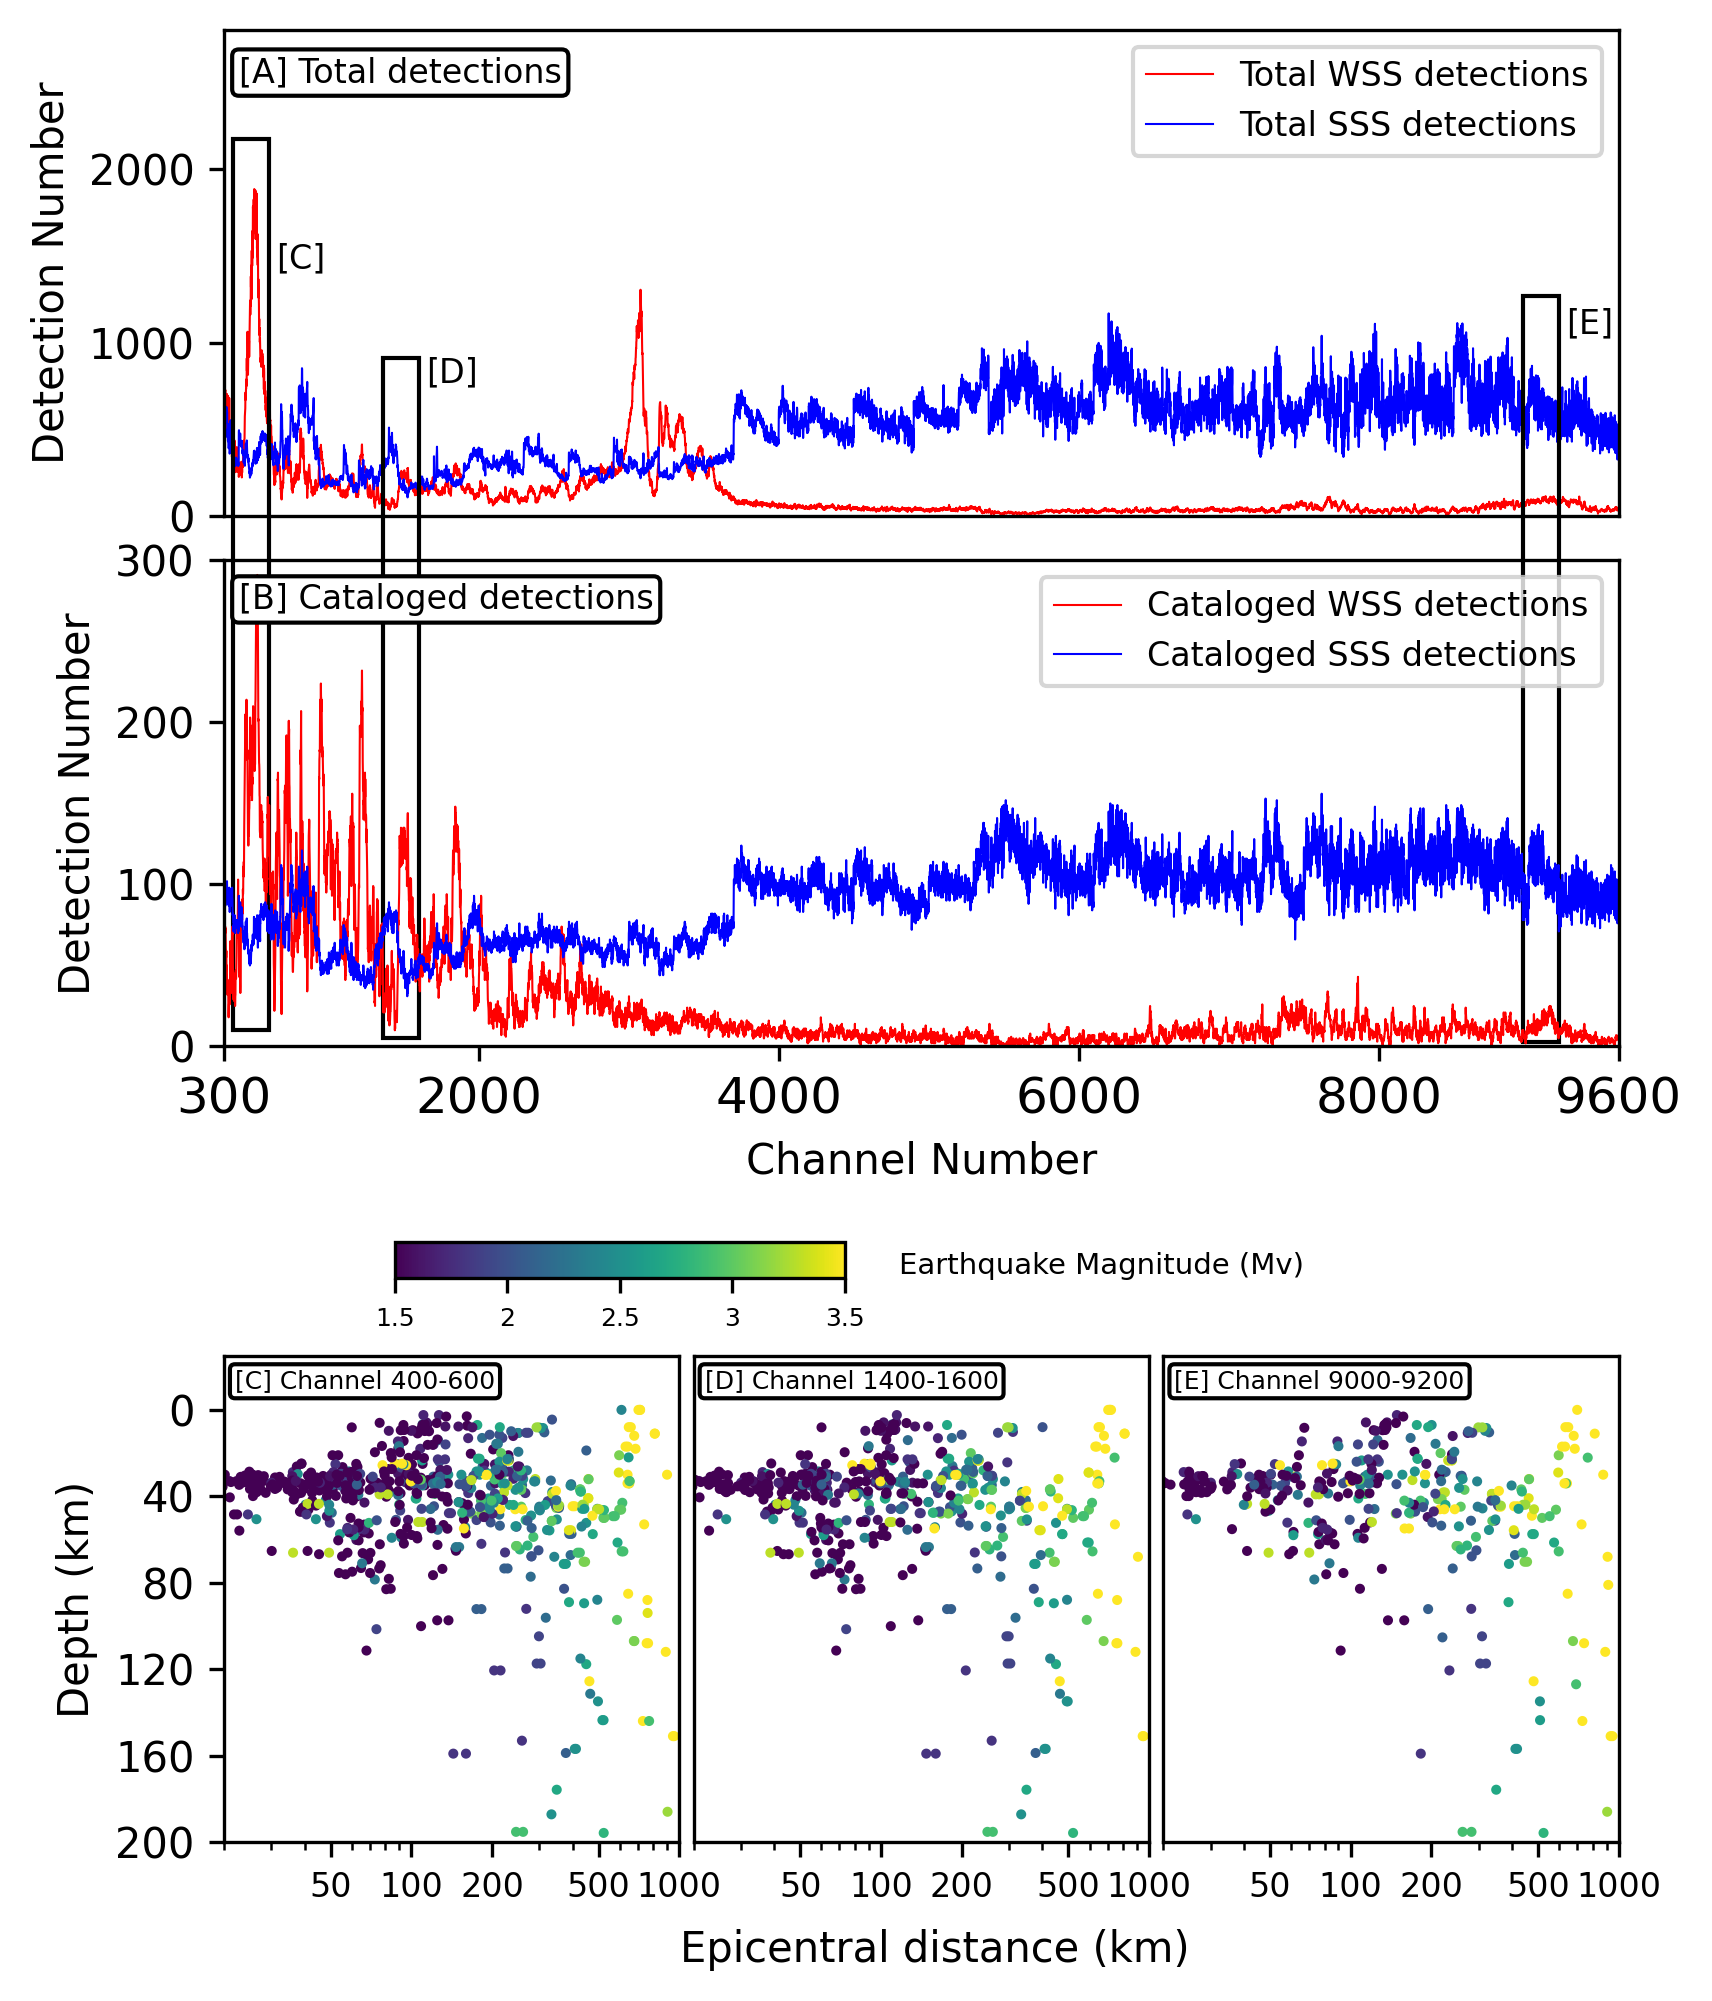

In [138]:
fig=plt.figure(figsize=(6,8),dpi=300)
fig.subplots_adjust(hspace=0.2,wspace=0.1)

ax1 = plt.subplot2grid(shape=(7,9), loc=(0,0), colspan=9,rowspan=2)
ax2 = plt.subplot2grid(shape=(7,9), loc=(2,0), colspan=9,rowspan=2)

ax3 = plt.subplot2grid(shape=(7,9), loc=(5,0), colspan=3,rowspan=2)
ax4 = plt.subplot2grid(shape=(7,9), loc=(5,3), colspan=3,rowspan=2)
ax5 = plt.subplot2grid(shape=(7,9), loc=(5,6), colspan=3,rowspan=2)

axs=[ax1,ax2,ax3,ax4,ax5]
for ax in axs:
    ax.set_xticks([])
    ax.set_xticklabels([])
    
rect = patches.Rectangle((360,10), 240, 550, linewidth=1, edgecolor='k', facecolor='none',clip_on=False,zorder=0)
ax2.add_patch(rect)
ax2.text(650,480,'[C]',fontsize=8,c='k')
rect = patches.Rectangle((1360,5), 240, 420, linewidth=1, edgecolor='k', facecolor='none',clip_on=False)
ax2.add_patch(rect)
ax2.text(1650,410,'[D]',fontsize=8,c='k')
rect = patches.Rectangle((8960,3), 240, 460, linewidth=1, edgecolor='k', facecolor='none',clip_on=False)
ax2.add_patch(rect)
ax2.text(9250,440,'[E]',fontsize=8,c='k')  

ax1.plot(np.arange(200),all_wss[:200],linewidth=0.5,c='r')
ax1.plot(np.arange(300,9600),all_wss[300:9600],linewidth=0.5,c='r',label='Total WSS detections')
ax1.plot(np.arange(200),all_sss[:200],linewidth=0.5,c='b')
ax1.plot(np.arange(300,9599),all_sss[300:9599],linewidth=0.5,c='b',label='Total SSS detections')
ax1.legend(fontsize=8,loc='upper right')
ax1.set_ylabel('Detection Number')
ax1.set_xlim(300,9600)
ax1.set_ylim(0,2800)
ax1.text(400,2500,'[A] Total detections',bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2'),c='k',fontsize=8)

ax2.plot(np.arange(200),cataloged_wss[:200],linewidth=0.5,c='r',alpha=1)
ax2.plot(np.arange(300,9600),cataloged_wss[300:9600],linewidth=0.5,c='r',alpha=1,label='Cataloged WSS detections')
ax2.plot(np.arange(200),cataloged_sss[:200],linewidth=0.5,c='b')
ax2.plot(np.arange(300,9599),cataloged_sss[300:9599],linewidth=0.5,c='b',label='Cataloged SSS detections')
ax2.legend(fontsize=8,loc='upper right')
ax2.set_ylabel('Detection Number')
ax2.set_xlim(300,9600)
ax2.set_xticks([300,2000,4000,6000,8000,9599])
ax2.set_xticklabels([300,2000,4000,6000,8000,9600],fontsize=12)
ax2.set_xlabel('Channel Number')
ax2.set_ylim(0,300)
ax2.text(400,270,'[B] Cataloged detections',bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2'),c='k',fontsize=8)

sc=ax3.scatter(sec1_dist,sec1_dep,c=sec1_mag, s=2,vmin=1.5,vmax=3.5)
ax3.set_xscale('log')
ax3.set_xlim(20,10**3)
ax3.set_ylim(200,-25)
ax3.text(22,-10,'[C] Channel 400-600',bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2'),c='k',fontsize=6)

ax4.scatter(sec2_dist,sec2_dep,c=sec2_mag, s=2,vmin=1.5,vmax=3.5)
ax4.set_xscale('log')
ax4.set_xlim(20,10**3)
ax4.set_ylim(200,-25)
ax4.text(22,-10,'[D] Channel 1400-1600',bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2'),c='k',fontsize=6)


ax5.scatter(sec3_dist,sec3_dep,c=sec3_mag, s=2,vmin=1.5,vmax=3.5)
ax5.set_xscale('log')
ax5.set_xlim(20,10**3)
ax5.set_ylim(200,-25)
ax5.text(22,-10,'[E] Channel 9000-9200',bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2'),c='k',fontsize=6)

for ax in [ax3,ax4,ax5]:
    ax.set_xticks([50,100,200,500,1000])
    ax.set_xticklabels([50,100,200,500,1000],fontsize=8)
    ax.set_yticks([])
ax3.set_yticks([0,40,80,120,160,200])
ax3.set_yticklabels([0,40,80,120,160,200])
ax3.set_ylabel('Depth (km)')
fig.text(0.52, 0.08, 'Epicentral distance (km)', ha='center', va='center')

cax=fig.add_axes([0.22,0.36,0.25,0.015])
cbar=fig.colorbar(sc, cax=cax,orientation='horizontal')
fig.text(0.5,0.365,'Earthquake Magnitude (Mv)',va='center',fontsize=7)
cbar.set_ticks([1.5,2,2.5,3,3.5])
cbar.set_ticklabels([1.5,2,2.5,3,3.5])
sc.set_clim(1.5,3.5)
cbar.ax.tick_params(labelsize=6)

In [5]:
### pass amplitude threshold trend, 0-1000 km    

def cal_array_index(distance):
    return(int(distance//50))

min_mag=np.zeros(20)+10
detected_mag=[]
undetected_mag=[]
dista=[]
for i in range(20):
    detected_mag.append([])
    undetected_mag.append([])  
    
for i in range(len(eindex)):
    
    if distance[i]<=1000:
        index=cal_array_index(distance[i])
        
        if ssss[i]==1 or wsss[i]==1:
            
            detected_mag[index].append(magnitude[i])
            if magnitude[i]<min_mag[index]:
                min_mag[index]=magnitude[i]

        else:
            undetected_mag[index].append(magnitude[i])
            
rate=[]
for i in range(20):
    cum_d=0
    cum_und=0
    for j in range(i+1):
        cum_d+=len(detected_mag[j])
        cum_und+=len(undetected_mag[j])
    if cum_d+cum_und>0:
        rate.append(cum_d/(cum_d+cum_und)*100)
    else:
        rate.append(0)
    
# rate=[]
# for i in range(20):
#     rate.append(len(detected_mag[i])/(len(detected_mag[i])+len(undetected_mag[i]))*100)
    
median_mag=[]
for i in range(20):
    median_mag.append(np.median(detected_mag[i]))
    
bins=[1,1.2,1.4,1.6,1.8,2,2.2,2.4,2.6,2.8,3,3.2,3.4,3.6,3.8,4,4.2,4.4,4.6,4.8,5]

def find_magindex(event,bins=bins):
    
    for i in range(len(bins)-1):
        if event>=bins[i+1]:
            pass
        else:
            break
            
    return i

cum_count=np.zeros(len(bins)-1)
dec_count=np.zeros(len(bins)-1)
for i in range(len(detected_mag)):
    for event in detected_mag[i]:
        index=find_magindex(event)
        cum_count[index]+=1
        dec_count[index]+=1
    for event in undetected_mag[i]:
        index=find_magindex(event)
        cum_count[index]+=1
        
master_dec=[]
for i in range(len(detected_mag)):
    master_dec.extend(detected_mag[i])
master_all=[]
for i in range(len(detected_mag)):
    master_all.extend(detected_mag[i])
    master_all.extend(undetected_mag[i])

/home/yaolinm/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yaolinm/.local/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


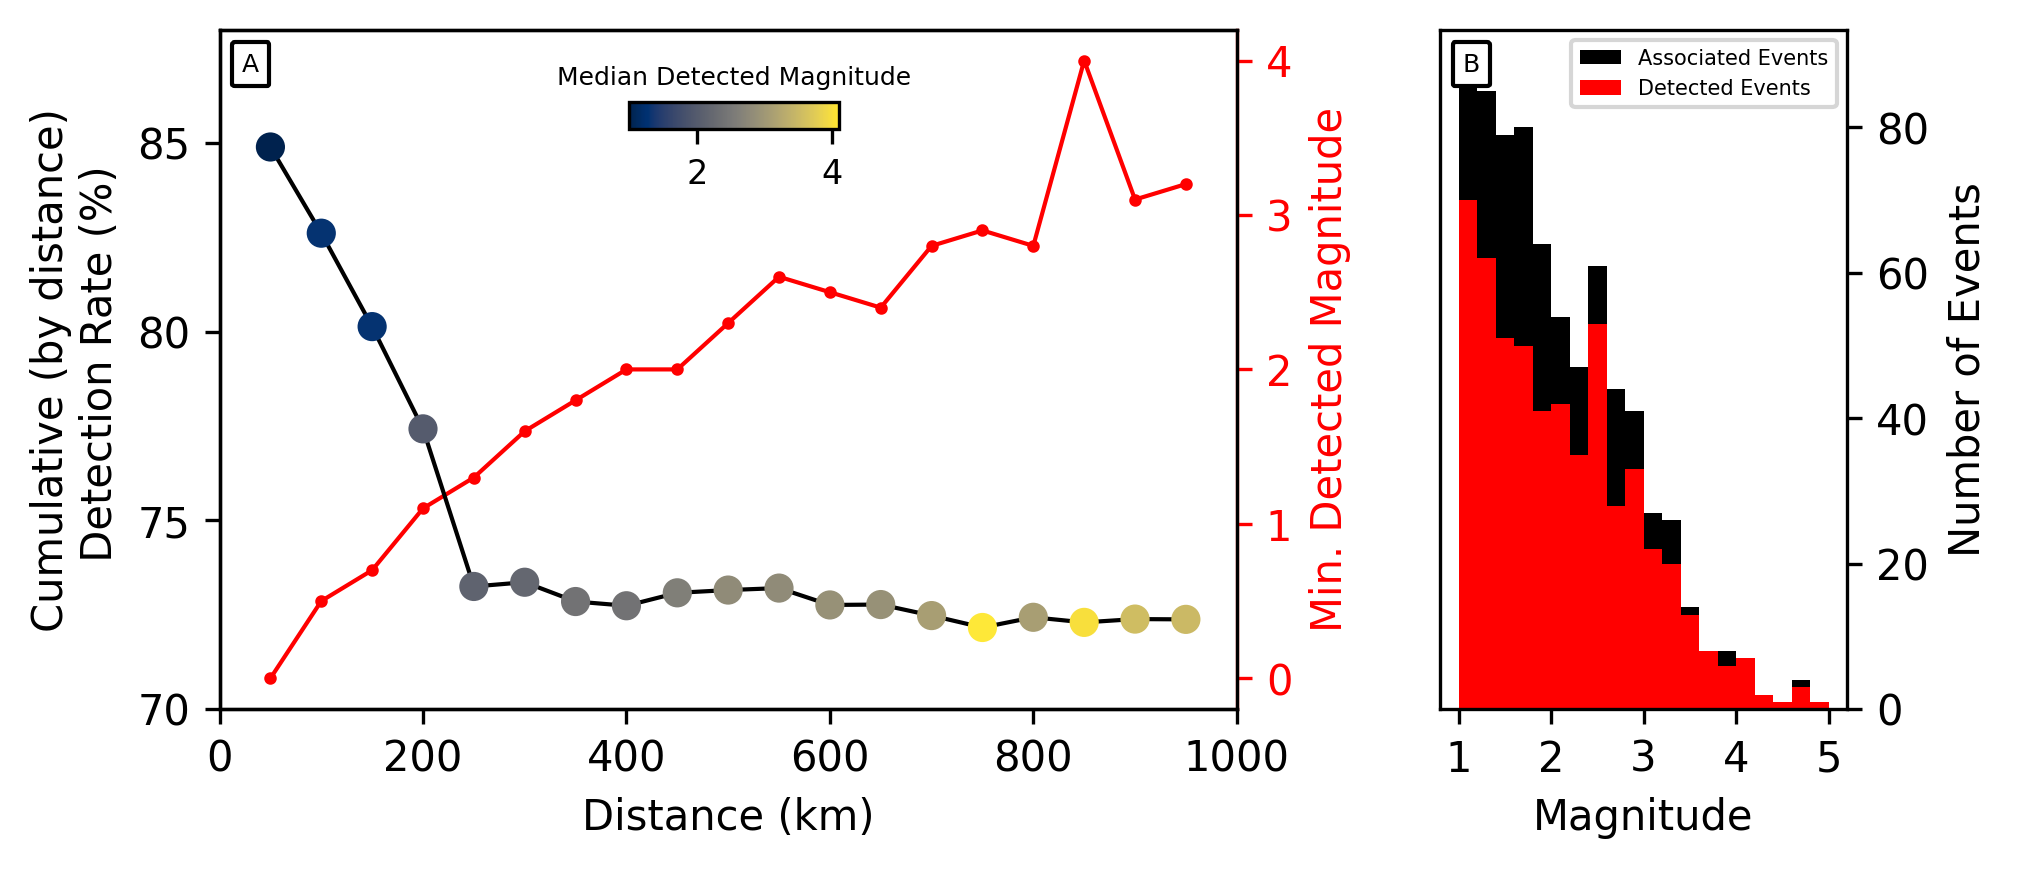

In [48]:
### F15

fig=plt.figure(figsize=(7,3),dpi=300)
fig.subplots_adjust(hspace=0,wspace=0.5)

ax1=plt.subplot2grid(shape=(2,3), loc=(0,0), colspan=2,rowspan=2)
ax2=plt.subplot2grid(shape=(2,3), loc=(0,2), colspan=1,rowspan=2)
ax11=ax1.twinx()
ax1.set_zorder(ax11.get_zorder()+1)
ax1.patch.set_visible(False)


dists=np.arange(0,950,50)+50
ax1.plot(dists,rate[:-1],lw=1,c='k',zorder=1)
scatter=ax1.scatter(dists,rate[:-1],marker='o',c=median_mag[:-1],cmap='cividis',zorder=10)
ax11.plot(dists,min_mag[:-1],lw=1,marker='o',ms=2,c='r',zorder=5)

cax=fig.add_axes([0.32,0.77,0.1,0.03])
cbar=fig.colorbar(scatter,cax=cax,orientation='horizontal')
cbar.set_label('Median Detected Magnitude',fontsize=6)
cbar.ax.tick_params(labelsize=8)
cbar.ax.xaxis.set_label_position('top')

ax1.set_xlim(0,1000)
ax1.set_ylim(70,88)
ax1.set_yticks([70,75,80,85])
ax1.set_yticklabels([70,75,80,85])
ax1.set_xlabel('Distance (km)')
ax1.set_ylabel('Cumulative (by distance)\n Detection Rate (%)')
ax11.set_ylabel('Min. Detected Magnitude',c='r')
ax11.spines['right'].set_color('red') 
ax11.tick_params(colors='red')
at=AnchoredText('A',prop=dict(size=6), frameon=True,loc=2)
at.patch.set_boxstyle('round',pad=0,rounding_size=0.1)
ax1.add_artist(at)

ax2.yaxis.set_label_position('right')
ax2.yaxis.tick_right()
ax2.set_ylabel('Number of Events')
ax2.set_xlabel('Magnitude')
ax2.set_xticks([1,2,3,4,5])
ax2.set_xticklabels([1,2,3,4,5])
ax2.hist(master_all,bins,color='k',label='Associated Events')
ax2.hist(master_dec,bins,color='r',label='Detected Events')
ax2.legend(fontsize=5)
at=AnchoredText('B',prop=dict(size=6), frameon=True,loc=2)
at.patch.set_boxstyle('round',pad=0,rounding_size=0.1)
ax2.add_artist(at)

In [160]:
ids=np.zeros(20)
for i in range(len(eindex)):
    
    if distance[i]<=1000:
        index=cal_array_index(distance[i])
        ids[index]+=1

In [10]:
dframe=pd.read_excel('/nfs/turbo/lsa-zspica/work/yaolinm/for_jiuxun/JMA.xlsx')
magnitude=dframe['Magnitude']
latitude=dframe['Latitude']
longitude=dframe['Longitude']
date=dframe['Date']
time=dframe['Time']
depth=dframe['Depth']
index=dframe['Index']
for i in range(len(magnitude)):
    if magnitude[i] !=magnitude[i]:
        magnitude[i]=0
    else:
        magnitude[i]=float(magnitude[i][0:3])
        
### matching with catalog, cal distances first

daslat=39.2633725374648 
daslon=142.144805409815
distances=[]
mag=[]
dep=[]
ind=[]
event_time=[]
lati=[]
long=[]
for i in range(len(latitude)):
    if isnan(latitude[i]) == False and isnan(longitude[i]) == False:
        distances.append(cal_dis(daslat,daslon,latitude[i],longitude[i]))
        lati.append(latitude[i])
        long.append(longitude[i])
        
        event_time.append(UTC(date[i])+3600*time[i].hour+60*time[i].minute+time[i].second+time[i].microsecond*0.000001)
        ind.append(index[i])
        
        if magnitude[i]!=magnitude[i]:
            mag.append('unknown')
        else:
            mag.append(magnitude[i])
            
        if depth[i]!=depth[i]:
            dep.append('unknown')
        else:
            dep.append(float(depth[i]))               

/tmp/ipykernel_3240539/1812364423.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  magnitude[i]=float(magnitude[i][0:3])
/tmp/ipykernel_3240539/1812364423.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  magnitude[i]=0


In [11]:
def cal_array_index(distance):
    return(int(distance//50))


all_mag=[]
for i in range(20):
    all_mag.append([])

for i in range(len(ind)):
    
    if distances[i]<=1000:
        index=cal_array_index(distances[i])
        all_mag[index].append(mag[i])

    
median_all_mag=[]
for i in range(20):
    median_all_mag.append(np.median(all_mag[i]))
    

all_rate=[]

for i in range(20):
    cum_d=0
    cum_all=0
    for j in range(i+1):
        cum_d+=len(detected_mag[j])
        cum_all+=len(all_mag[j])
    all_rate.append(cum_d/cum_all*100)
    
master_allall=[]
for i in range(len(all_mag)):
    master_allall.extend(all_mag[i])

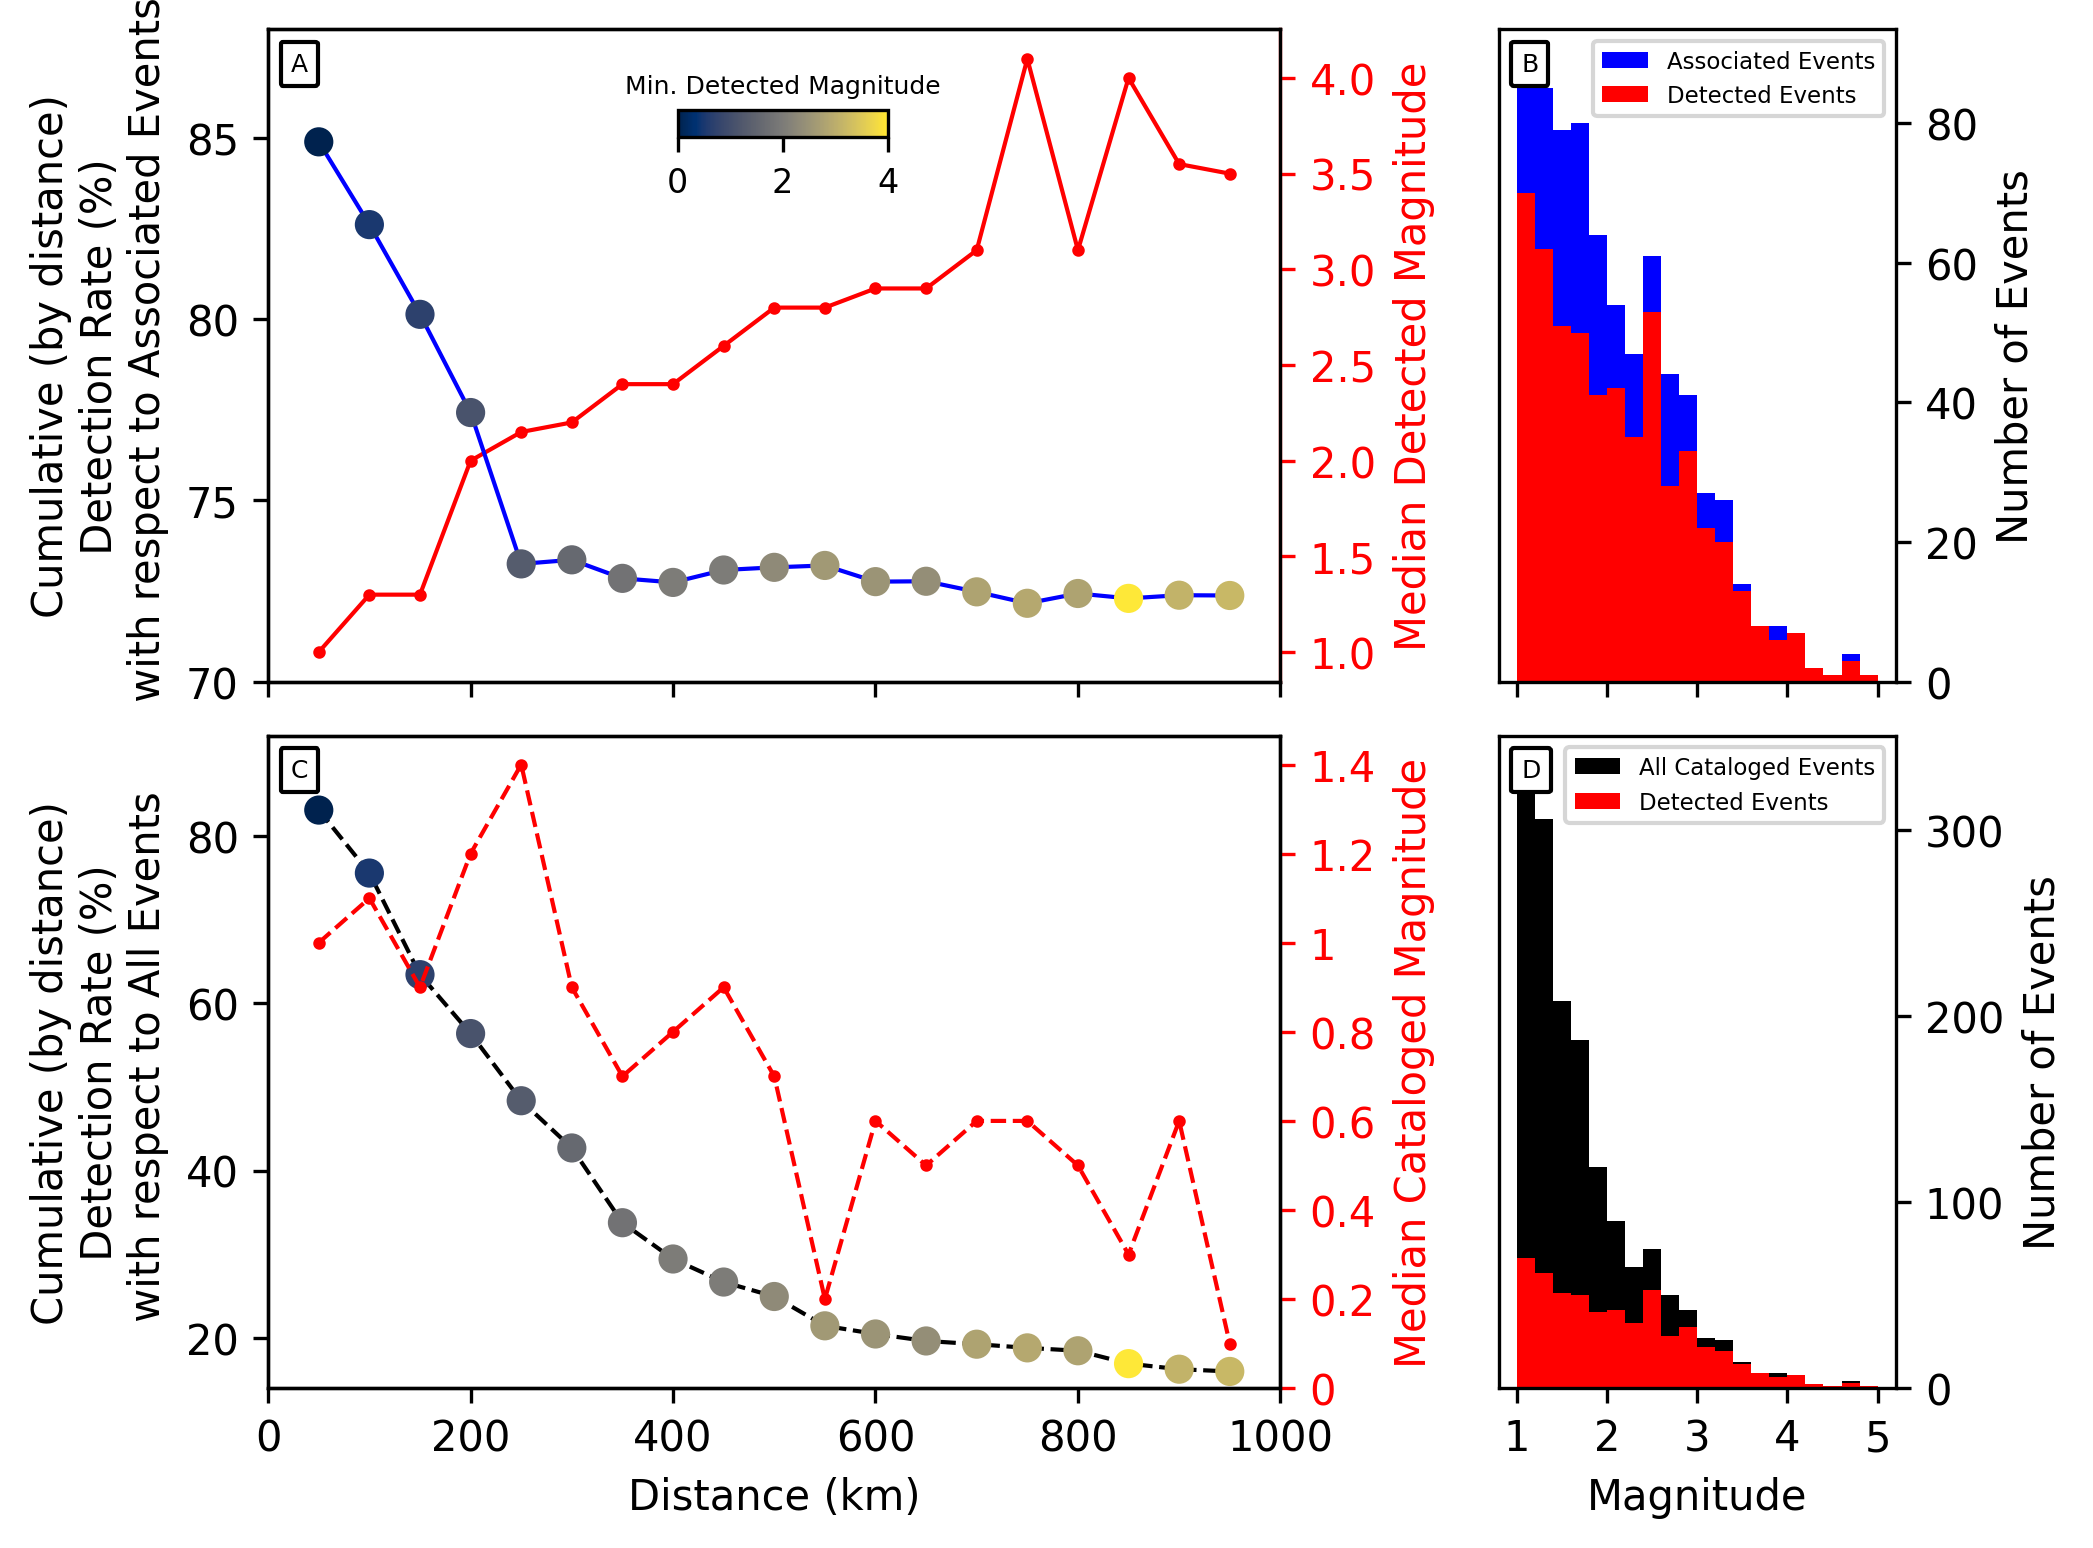

In [14]:
### F15

fig=plt.figure(figsize=(7,6),dpi=300)
fig.subplots_adjust(hspace=0.18,wspace=0.55)

ax1=plt.subplot2grid(shape=(4,3), loc=(0,0), colspan=2,rowspan=2)
ax2=plt.subplot2grid(shape=(4,3), loc=(0,2), colspan=1,rowspan=2)
ax3=plt.subplot2grid(shape=(4,3), loc=(2,0), colspan=2,rowspan=2)
ax4=plt.subplot2grid(shape=(4,3), loc=(2,2), colspan=1,rowspan=2)
ax11=ax1.twinx()
ax31=ax3.twinx()
ax1.set_zorder(ax11.get_zorder()+1)
ax1.patch.set_visible(False)


### left panels
dists=np.arange(0,950,50)+50
ax1.plot(dists,rate[:-1],lw=1,c='b',zorder=1)
scatter=ax1.scatter(dists,rate[:-1],marker='o',c=min_mag[:-1],cmap='cividis',zorder=10)
ax11.plot(dists,median_mag[:-1],lw=1,marker='o',ms=2,c='r',zorder=5)

cax=fig.add_axes([0.32,0.82,0.1,0.015])
cbar=fig.colorbar(scatter,cax=cax,orientation='horizontal')
cbar.set_label('Min. Detected Magnitude',fontsize=6)
cbar.ax.tick_params(labelsize=8)
cbar.ax.xaxis.set_label_position('top')

ax1.set_xlim(0,1000)
ax1.set_ylim(70,88)
ax1.set_yticks([70,75,80,85])
ax1.set_yticklabels([70,75,80,85])
ax1.set_xticks([0,200,400,600,800,1000])
ax1.set_xticklabels(['','','','','',''])

ax1.set_ylabel('Cumulative (by distance)\n Detection Rate (%) \n with respect to Associated Events')
ax11.set_ylabel('Median Detected Magnitude',c='r')
ax11.spines['right'].set_color('red') 
ax11.tick_params(colors='red')
at=AnchoredText('A',prop=dict(size=6), frameon=True,loc=2)
at.patch.set_boxstyle('round',pad=0,rounding_size=0.1)
ax1.add_artist(at)


ax3.plot(dists,all_rate[:-1],lw=1,c='k',ls='--',zorder=1)
scatter=ax3.scatter(dists,all_rate[:-1],marker='o',c=min_mag[:-1],cmap='cividis',zorder=10)
ax31.plot(dists,median_all_mag[:-1],lw=1,marker='o',ms=2,c='r',ls='--',zorder=5)

ax3.set_xlim(0,1000)
ax3.set_ylim(14,92)
ax3.set_xlabel('Distance (km)')
ax3.set_xticks([0,200,400,600,800,1000])
ax3.set_xticklabels([0,200,400,600,800,1000])
ax31.set_yticks([0,0.2,0.4,0.6,0.8,1,1.2,1.4])
ax31.set_yticklabels([0,0.2,0.4,0.6,0.8,1,1.2,1.4])

ax3.set_ylabel('Cumulative (by distance)\n Detection Rate (%) \n with respect to All Events')
ax31.set_ylabel('Median Cataloged Magnitude',c='r')
# ax31.spines['right'].set_color('red')
ax31.tick_params(colors='red')
at=AnchoredText('C',prop=dict(size=6), frameon=True,loc=2)
at.patch.set_boxstyle('round',pad=0,rounding_size=0.1)
ax3.add_artist(at)


### right panels
ax2.yaxis.set_label_position('right')
ax2.yaxis.tick_right()
ax2.set_ylabel('Number of Events')
ax2.set_xticks([1,2,3,4,5])
ax2.set_xticklabels(['','','','',''])
ax2.hist(master_all,bins,color='b',label='Associated Events')
ax2.hist(master_dec,bins,color='r',label='Detected Events')
ax2.legend(fontsize=5.5)
at=AnchoredText('B',prop=dict(size=6), frameon=True,loc=2)
at.patch.set_boxstyle('round',pad=0,rounding_size=0.1)
ax2.add_artist(at)

ax4.yaxis.set_label_position('right')
ax4.yaxis.tick_right()
ax4.set_ylabel('Number of Events')
ax4.set_xlabel('Magnitude')
ax4.set_xticks([1,2,3,4,5])
ax4.set_xticklabels([1,2,3,4,5])
ax4.hist(master_allall,bins,color='k',label='All Cataloged Events')
ax4.hist(master_dec,bins,color='r',label='Detected Events')
ax4.legend(fontsize=5.5)
at=AnchoredText('D',prop=dict(size=6), frameon=True,loc=2)
at.patch.set_boxstyle('round',pad=0,rounding_size=0.1)
ax4.add_artist(at)

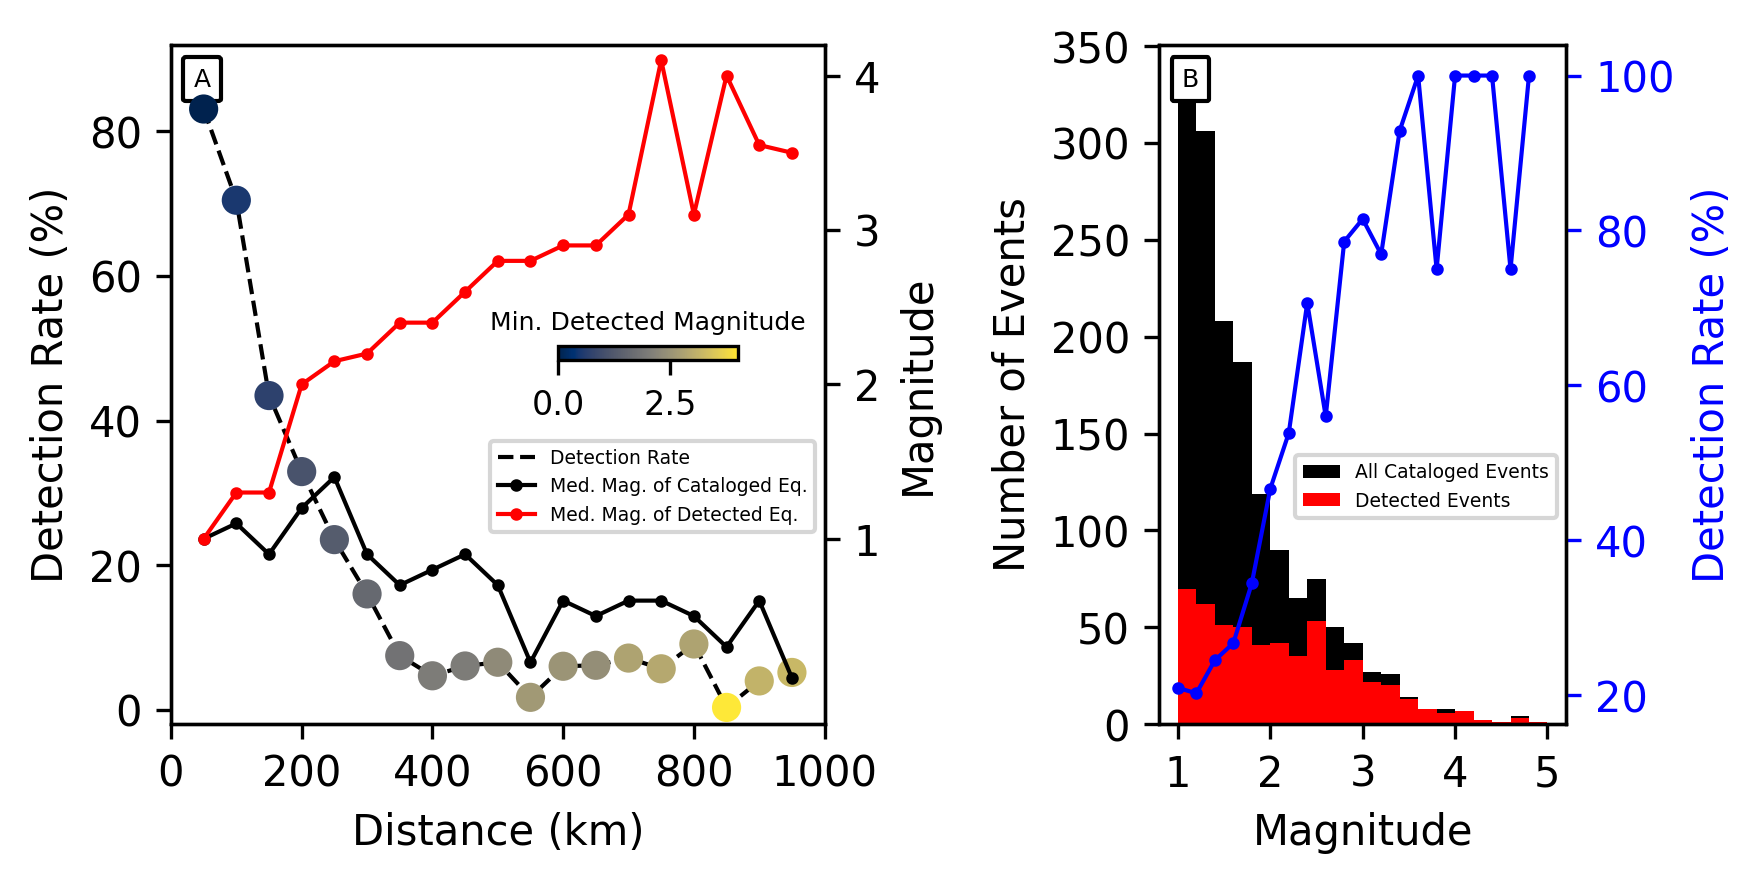

In [79]:
### F15

fig=plt.figure(figsize=(6,3),dpi=300)
fig.subplots_adjust(hspace=0.18,wspace=0.55)

ax3=plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=3,rowspan=2)
ax4=plt.subplot2grid(shape=(2,6), loc=(0,4), colspan=2,rowspan=2)
ax31=ax3.twinx()
# ax1.set_zorder(ax11.get_zorder()+1)
# ax1.patch.set_visible(False)

ax3.plot(dists,rates[:-1],lw=1,c='k',ls='--',zorder=999)
scatter=ax3.scatter(dists,rates[:-1],marker='o',c=min_mag[:-1],cmap='cividis',zorder=999)
ax31.plot(-100,100,ls='--',lw=1,c='k',label='Detection Rate')#for legend
ax31.plot(dists,median_all_mag[:-1],lw=1,marker='o',ms=2,c='k',zorder=5,ls='-',label='Med. Mag. of Cataloged Eq.')
ax31.plot(dists,median_mag[:-1],lw=1,marker='o',ms=2,c='r',zorder=5,label='Med. Mag. of Detected Eq.')
ax31.legend(fontsize=4.5,loc='center right',bbox_to_anchor=(0.5, 0., 0.5, 0.7))
ax3.set_xlim(0,1000)
ax3.set_ylim(-2,92)
ax31.set_xlim(0,1000)
ax31.set_ylim(-0.2,4.2)
ax3.set_xlabel('Distance (km)')
ax3.set_xticks([0,200,400,600,800,1000])
ax3.set_xticklabels([0,200,400,600,800,1000])
ax31.set_yticks([1,2,3,4])
ax31.set_yticklabels([1,2,3,4])

ax3.set_ylabel('Detection Rate (%)')
ax31.set_ylabel('Magnitude')
# ax31.spines['right'].set_color('red')
# ax31.tick_params(colors='red')
at=AnchoredText('A',prop=dict(size=6), frameon=True,loc=2)
at.patch.set_boxstyle('round',pad=0,rounding_size=0.1)
ax3.add_artist(at)

cax=fig.add_axes([0.34,0.53,0.1,0.015])
cbar=fig.colorbar(scatter,cax=cax,orientation='horizontal')
cbar.set_label('Min. Detected Magnitude',fontsize=6)
cbar.ax.tick_params(labelsize=8)
cbar.ax.xaxis.set_label_position('top')

# ax4.yaxis.set_label_position('right')
# ax4.yaxis.tick_right()
ax4.set_ylabel('Number of Events')
ax4.set_xlabel('Magnitude')
ax4.set_xticks([1,2,3,4,5])
ax4.set_xticklabels([1,2,3,4,5])
sorted_all,sorted_bins,_=ax4.hist(master_allall,bins,color='k',label='All Cataloged Events')
sorted_dec,sorted_bins,_=ax4.hist(master_dec,bins,color='r',label='Detected Events')
ax4.legend(fontsize=4.5,loc='center right',bbox_to_anchor=(0.5, 0., 0.5, 0.7))
at=AnchoredText('B',prop=dict(size=6), frameon=True,loc=2)
at.patch.set_boxstyle('round',pad=0,rounding_size=0.1)
ax4.add_artist(at)

ax44=ax4.twinx()
ax44.plot(sorted_bins[:-1],100*np.array(sorted_dec)/np.array(sorted_all),c='b',marker='o',markersize=2,lw=1)
ax44.set_ylabel('Detection Rate (%)',c='b')
ax44.tick_params(colors='b')

In [67]:
len(detected_mag)
rates=[]
for i in range(20):
    rates.append(100*len(detected_mag[i])/len(all_mag[i]))